# Group 4

Members:

- Li Lingwei
- Leong Yu Rong
- Varun Chitalia
- Xia Tian
- Zhou Tianqi

# <a id = "toc"></a> Table Of Contents

## 0. [Summary](#summary)

## 1. [Machine Learning Strategies](#ml)

## 2. [Mean-Reversion Strategy](#meanreversion)

## 3. [Momentum Strategy](#momentum)

## 4. [Write-Ups](#writeup)

## 5. [Contribution Statements](#statement)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf
yf.pdr_override()

import warnings
warnings.filterwarnings("ignore")

# <a id = "summary"></a> <font color = "orange"> 0. Summary </font>[back to table of contents](#toc)

We present a summary of the backtesting results of our strategies in the table below. For all models, backtesting covered the in-sample period of Nov 2004 - Oct 2023, with the exception of *Random Forest*, which covered a period of 2017 to 2023. From our evaluation, it seems that machine learning have a slight advantage in producing strategies which provide a greater amount of returns over the in-sample period over traditional momentum and reversion-based strategies. This is not to be unexpected, giving that machine learning is able to incorporate information from various sources to train the models. Our aim is to achieve a balance between maximizing total returns and maintaining a reasonable risk tolerance. In our course of strategy testing, certain models were rejected despite providing higher returns due to the unrealistic risks required.

In [9]:
overall_summary = pd.DataFrame({"Cummulative Capital($)":[444663.04, 373659.60, 706948.88, 515674.31, 495902.12],
                                "Sharpe Ratio": [0.608, 1.089, 1.035, 0.607, 0.747],
                                "CAGR(%)": [9.16, 20.81, 12.83, 10.00, 9.02],
                                "Max Drawdown(%)": [86.4, 19.3, 111.2, 147.3, 106.1]},
                               index = ["Baseline: SPY", "Random Forest*", "ARIMA", "Mean Reversion", "SMA"])
overall_summary

Cummulative Capital($)  Sharpe Ratio  CAGR(%)  Max Drawdown(%)
Baseline: SPY                444663.04         0.608     9.16             86.4
Random Forest*               373659.60         1.089    20.81             19.3
ARIMA                        706948.88         1.035    12.83            111.2
Mean Reversion               515674.31         0.607    10.00            147.3
SMA                          495902.12         0.747     9.02            106.1

# <a id = "ml"></a><font color = "orange">1. Machine Learning Strategies</font> [back to table of contents](#toc)

## <font color = "blue">ARIMA</font>

> Strategy Overview

- We first identified correlated and uncorrelated stocks and indices as well as possible currencies to train the model on.
- We also identified several possible value of lags. To capture short, medium and long term trends, the list of lags we shortlisted covers approximately up to 1 month for short lags, 1 - 3 months for medium lags and 6 - 12 months for long lags.
- We then iterate through a combination of these input and technical features to train an ARIMA(2,0,0) model, with a 60-40 train-test split.
- ARIMA(2,0,0) model was identified through a grid search of possible ARIMA parameters.
- For each trained model based on the randomized features, we calculated the cummulative returns for the test set. We only shortlisted models that have cummulative returns of 2.0 times or more for the in-sample backtesting.
- Based on the shortlisted models, we calculated the cummulative returns for the in-sample period. This was done to discard models which may have performed exceptionally well for the test sample (of period 2016/2019 - 2023), but achieved poor performance overall for the in-sample backtesting.

> Entry and Exit Points

- A simple trend-following strategy was used to generate the buy-sell signals.
- If the model predicts the price will be positive the next day, we will buy into the stock.
- Otherwise we will proceed to close the long position and short the stock instead.

### Set Up

In [2]:
key_stock = "SPY"
stock_ticker = ["AAPL", "AMZN", "GOOGL", "GIS", "PG",
                "MRK", "AMT", "MCD", "BMY", "DIS",
                "WMT", "MSFT", "DELL", "VMW", "KKR",
                "FERG", "VEEV"]
currency_ticker = ["DEXJPUS", "DEXCHUS", "DEXINUS", "DEXUSEU", "DEXKOUS"]
#index_ticker = ["VIXCLS", "GVZCLS", "DAAA", "DJUA", "WILLMICROCAPPR", "DJTA", "DJIA"]
index_ticker = ["GLD", "VTI", "DIA", "SHV", "RWM"]
windows = [[21, 63, 252],
           [20, 50, 200],
           [12, 50, 200],
           [26, 50, 200],
           [10, 26, 126],
           [5, 21, 126],
           [10, 50, 126],
           ]

start = dt.datetime(2004, 11, 1)
end = dt.datetime(2023, 10, 31)

In [3]:
stock_data = pdr.get_data_yahoo([key_stock]+stock_ticker,
                                start = start,
                                end = end)
currency_data = pdr.get_data_fred(currency_ticker,
                                  start = start,
                                  end = end)
index_data = pdr.get_data_yahoo(index_ticker,
                               start = start,
                               end = end)

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  5 of 5 completed


In [4]:
stock_data.head(3)

Adj Close                                                    \
                AAPL        AMT   AMZN        BMY DELL        DIS FERG   
Date                                                                     
2004-11-01  0.793943  13.572985  1.755  11.573818  NaN  20.303408  NaN   
2004-11-02  0.809837  13.849021  1.812  11.484637  NaN  20.488495  NaN   
2004-11-03  0.837236  13.793813  1.796  11.771996  NaN  20.633348  NaN   

                                     ...     Volume                         \
                  GIS     GOOGL KKR  ...      GOOGL KKR      MCD       MRK   
Date                                 ...                                     
2004-11-01  12.246771  4.905656 NaN  ...  488507004 NaN  4408100  69787997   
2004-11-02  12.207886  4.876627 NaN  ...  453398148 NaN  4254600  67250684   
2004-11-03  12.360656  4.796547 NaN  ...  554992452 NaN  5922500  51887842   

                                                            
                MSFT       PG       SPY VEEV VMW       WMT  
Date                                                        
2004-11-01  72930900  7285200  36720900  NaN NaN   8974600  
2004-11-02  89417100  8559400  56210000  NaN NaN  10796700  
2004-11-03  79666700  6472800  76960200  NaN NaN  11109500  

[3 rows x 108 columns]

In [5]:
currency_data.head(3)

DEXJPUS  DEXCHUS  DEXINUS  DEXUSEU  DEXKOUS
DATE                                                   
2004-11-01   106.41   8.2765    45.33   1.2741   1119.0
2004-11-02   106.29   8.2764    45.40   1.2703   1115.0
2004-11-03   106.20   8.2765    45.33   1.2787   1116.0

In [6]:
index_data = index_data["Adj Close"]
index_data.head(3)

DIA  GLD  RWM  SHV        VTI
Date                                           
2004-11-01  64.949402  NaN  NaN  NaN  38.461372
2004-11-02  64.833328  NaN  NaN  NaN  38.370335
2004-11-03  65.594330  NaN  NaN  NaN  38.867458

### Feature Selection and Model Training

In [7]:
# Loading Algorithm

# ARIMA
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [8]:
# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for assessment
from sklearn.metrics import mean_squared_error

In [9]:
# Defining a Features class to streamline the training process and model selection
class Features:
    def __init__(self, key_stock, stock_ticker, stock_data, currency_data, index_data, return_period = 5, windows = [21, 63, 252]):
        self._return_period = return_period
        self._windows = windows
        self._key_stock = key_stock
        self._stock_ticker = stock_ticker
        self._stock_data = stock_data.copy()
        self._currency_data = currency_data.copy()
        self._index_data = index_data.copy()

    def get_stock_tickers(self):
        return self._stock_ticker

    def get_currency_tickers(self):
        return self._currency_data.columns

    def get_index_tickers(self):
        return self._index_data.columns
        
    def get_return_period(self):
        return self._return_period

    def get_window(self):
        return self._windows

    def dependent_variable(self):
        Y = (np.log(self._stock_data.loc[ : , ("Adj Close", self._key_stock)]).diff(self._return_period).shift(-self._return_period))
        Y.name = (self._key_stock + "_actual")
        return Y

    def related_stock_lags(self):
        df = (np.log(self._stock_data.loc[ : , ("Adj Close", tuple(self._stock_ticker))]).diff(self._return_period))
        df.columns = (df.columns.droplevel())
        return df

    def currency_lags(self):
        df = (np.log(self._currency_data).diff(self._return_period))
        return df

    def index_lags(self):
        df = (np.log(self._index_data).diff(self._return_period))
        return df

    def stock_lags(self):
        df = (pd.concat([np.log(self._stock_data.loc[ : , ("Adj Close", self._key_stock)]).diff(i) for i in [self._return_period, 
                                                                                                             self._return_period * 3, 
                                                                                                             self._return_period * 6, 
                                                                                                             self._return_period * 12]
                        ],
                        axis = 1
                       ).dropna()
             )
        df.columns = [f"{self._key_stock}_DT", f"{self._key_stock}_3DT", f"{self._key_stock}_6DT", f"{self._key_stock}_12DT"]
        return df

    def moving_averages(self):
        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            df = pd.concat([df, self._stock_data.loc[ : , ("Adj Close", self._key_stock)].rolling(window = i).agg(["mean"])],
                            axis = 1)
            COLS.append(f"{self._key_stock}_MA_{i}")
        df.columns = COLS
        df = df.dropna()
        return df

    def exponential_moving_average(self):
        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            df = pd.concat([df, self._stock_data.loc[ : , ("Adj Close", self._key_stock)].ewm(span = i,
                                                                                               min_periods = i)
                                                                                          .mean()],
                            axis = 1
                           )
            COLS.append(f"{self._key_stock}_EWM_{i}")
        df.columns = COLS
        df = df.dropna()
        return df

    def RSI(self, RS_Window):
        data = self._stock_data.loc[ : , ("Adj Close", self._key_stock)].to_frame().dropna()
        data.columns = ["Adj Close"]
        data["Diff"] = data["Adj Close"].diff()
        data.dropna(inplace = True)
        data["Gain"] = np.where(data["Diff"] > 0, data["Diff"], 0)
        data["Loss"] = np.where(data["Diff"] < 0, np.abs(data["Diff"]), 0)
        data["Gain_Mean"] = data["Gain"].rolling(window = RS_Window).mean()
        data["Loss_Mean"] = data["Loss"].rolling(window = RS_Window).mean()
        data["RS"] = pd.Series()
        data["RS"].iloc[RS_Window - 1] = (data["Gain_Mean"].iloc[RS_Window - 1] / data["Loss_Mean"].iloc[RS_Window - 1])
    
        for idx in range(RS_Window, len(data)):
            data["RS"].iloc[idx] =\
                (
                    (data["Gain_Mean"].iloc[idx - 1] * (RS_Window - 1) + data["Gain"].iloc[idx])
                    /
                    (data["Loss_Mean"].iloc[idx - 1] * (RS_Window - 1) + data["Loss"].iloc[idx])
                )
    
        data["RSI"] =\
            (
                100 - (100 / (1 + data["RS"]))
            )
    
        data.dropna(inplace = True)

        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            df = pd.concat([df, data.loc[ : , ("RSI")].rolling(window = i).agg(["mean"])],
                           axis = 1
                          )
            COLS.append(f"{self._key_stock}_RSI_{i}")
        df.columns = COLS
        df = df.dropna()
        return df

    def stochastic_osc(self):
        stoc_osc = self._stock_data.loc[ : , (["Adj Close", "Low", "High"], self._key_stock)]
        df = pd.DataFrame()
        COLS = []
        for i in self._windows:
            K =\
            (
                (stoc_osc["Adj Close"] - stoc_osc["Low"].rolling(window = i).min()) 
                /
                (stoc_osc["High"].rolling(window = i).max() - stoc_osc["Low"].rolling(window = i).min())
            )
            COLS.append(f"{self._key_stock}_K_{i}")
            
            D = K.rolling(window = i).mean()
            COLS.append(f"{self._key_stock}_D_{i}")
            
            df = (pd.concat([df, K, D],
                           axis = 1
                          )
                    .dropna()
                 )
        df.columns = COLS
        return df

    def rate(self):
        df = pd.DataFrame()
        COLS = []
        data = self._stock_data.loc[ : , ("Adj Close", self._key_stock)]
        for i in self._windows:
            df = pd.concat([df, data / data.shift(i)],
                            axis = 1
                           )
            COLS.append(f"{self._key_stock}_RATE_{i}")
        df.columns = COLS
        df = df.dropna()
        return df


In [10]:
# We randomize the input and technical features for training the model
feature_set = {}
for i in range(100):
    pick_stocks = [key_stock] + list(np.random.choice(stock_ticker, 5, replace = False))
    pick_currency = list(np.random.choice(currency_ticker, 2, replace = False))
    pick_index = list(np.random.choice(index_ticker, 3, replace = False))
    pick_period = np.random.choice(5) + 1
    pick_windows = windows[np.random.choice(len(windows))]
    feature_set[f"Set_{i}"] = Features(key_stock,
                                       pick_stocks,
                                       stock_data.loc[ : ,(["Adj Close", "Close", "High", "Low", "Open", "Volume"], tuple(pick_stocks))],
                                       currency_data[pick_currency],
                                       index_data[pick_index],
                                       return_period = pick_period,
                                       windows = pick_windows)

In [11]:
# Setting up the required dependent and independent variables
feature_data = {}
for set, features in feature_set.items():
    variables = (
                    pd
                    .concat([features.dependent_variable(),
                             features.related_stock_lags(),
                             features.currency_lags(),
                             features.index_lags(),
                             features.stock_lags(),
                             features.moving_averages(),
                             features.exponential_moving_average(),
                             features.RSI(14),
                             features.stochastic_osc(),
                             features.rate()],
                            axis = 1)
                    .dropna()
                    .iloc[ : :features.get_return_period(), :]
                )
    feature_data[set] = variables

In [12]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_ARIMA_model(arima_order):
    
    modelARIMA = stats.ARIMA(endog = Y_train,
                             exog = X_train_ARIMA,
                             order = arima_order)
    
    model_fit = modelARIMA.fit()
    
    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    
    return error

In [13]:
def assess_models(p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    
                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )
                    
                except:
                    continue
    # print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
    #       )
    return best_cfg

In [14]:
def return_Cumulative_Df(actual_values, predicted_values):
    predicted_values.index = actual_values.index
    df = pd.DataFrame([actual_values, predicted_values]).T
    df.columns = ["Actual_Returns" ,"Predicted_Returns"]
    
    # Simple trend following strategy
    df["trend_follow_signal"] = np.where(df["Predicted_Returns"] > 0, 1, -1)
    df["trend_Strategy_Returns"] = df["trend_follow_signal"].shift(1) * df["Actual_Returns"]
    df["trend_Cummulative_Returns"] = np.exp(df["trend_Strategy_Returns"].cumsum())
    
    return df

In [15]:
# Here we train the model based on the selected feature set
# We shortlist potential models for in-sample backtesting based on returns of test sample
# We have set a cut-off point of 2x returns for test samples
good_returns = {}

for set, data in feature_data.items():
    
    Y = data.loc[ : , data.columns[0]]
    X = data.loc[ : , data.columns[1:]]
    
    validation_size = 0.4 # this refers to testing set
    train_size = int(len(X) * (1 - validation_size))
    X_train, X_test = (X[0:train_size], X[train_size:len(X)])
    Y_train, Y_test = (Y[0:train_size], Y[train_size:len(X)])
    
    # Basic Set-up for ARIMA
    COLS = list(X.columns[1:10])
    X_train_ARIMA = (X_train.loc[ : , COLS])
    X_test_ARIMA = (X_test.loc[ : , COLS])
    
    train_len = len(X_train_ARIMA)
    test_len = len(X_test_ARIMA)
    total_len = len(X)
    
    # p_values = [0, 1, 2]
    # d_values = range(0, 2)
    # q_values = range(0, 2)
    # p, d, q = assess_models(p_values, d_values, q_values)
    
    modelARIMA = (stats.ARIMA(endog = Y_train,
                              exog = X_train_ARIMA,
                              order = [2, 0, 0]
                             )
                 )
    
    model_fit = modelARIMA.fit()
    
    train_len = len(X_train_ARIMA)
    test_len = len(X_test_ARIMA)
    total_len = len(X)
    
    predicted_test = (model_fit.predict(start = train_len - 1,
                                        end = total_len - 1,
                                        exog = X_test_ARIMA)[1: ]
                     )
    backtest_Test_Sample = return_Cumulative_Df(Y_test, predicted_test)
    final_returns = backtest_Test_Sample["trend_Cummulative_Returns"][-1]

    if final_returns > 2.0:
        predicted_InSample = (model_fit.predict(start = 0,
                                                end = total_len - 1,
                                                exog = X_test_ARIMA)
                             )
        backtest_In_Sample = return_Cumulative_Df(Y, predicted_InSample)
    
        good_returns[set] = (final_returns, backtest_Test_Sample, backtest_In_Sample)

/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yurongleong/.pyenv/versions/3.11.0b5/envs/MQF/lib/python3.11/site-packages/statsmodels/base/model.py:607: Convergence

In [16]:
for set in good_returns.keys():
    print(f"\n{set}:")
    print(f"{feature_set[set].get_currency_tickers()}\n"
          f"{feature_set[set].get_index_tickers()}\n"
          f"{feature_set[set].get_return_period()}\n"
          f"{feature_set[set].get_stock_tickers()}\n"
          f"{feature_set[set].get_window()}")


Set_3:
Index(['DEXJPUS', 'DEXUSEU'], dtype='object')
Index(['GLD', 'SHV', 'RWM'], dtype='object')
2
['SPY', 'VMW', 'WMT', 'MSFT', 'GOOGL', 'PG']
[10, 26, 126]

Set_10:
Index(['DEXCHUS', 'DEXINUS'], dtype='object')
Index(['GLD', 'VTI', 'SHV'], dtype='object')
3
['SPY', 'KKR', 'GIS', 'DIS', 'FERG', 'AMT']
[12, 50, 200]

Set_21:
Index(['DEXINUS', 'DEXKOUS'], dtype='object')
Index(['DIA', 'SHV', 'GLD'], dtype='object')
3
['SPY', 'GIS', 'WMT', 'AAPL', 'MRK', 'MCD']
[26, 50, 200]

Set_34:
Index(['DEXJPUS', 'DEXCHUS'], dtype='object')
Index(['GLD', 'RWM', 'VTI'], dtype='object')
4
['SPY', 'PG', 'AAPL', 'GIS', 'AMT', 'MSFT']
[21, 63, 252]

Set_38:
Index(['DEXKOUS', 'DEXCHUS'], dtype='object')
Index(['GLD', 'SHV', 'VTI'], dtype='object')
3
['SPY', 'WMT', 'MSFT', 'BMY', 'MRK', 'MCD']
[10, 50, 126]

Set_45:
Index(['DEXINUS', 'DEXKOUS'], dtype='object')
Index(['DIA', 'GLD', 'VTI'], dtype='object')
2
['SPY', 'FERG', 'BMY', 'PG', 'AMZN', 'GIS']
[12, 50, 200]


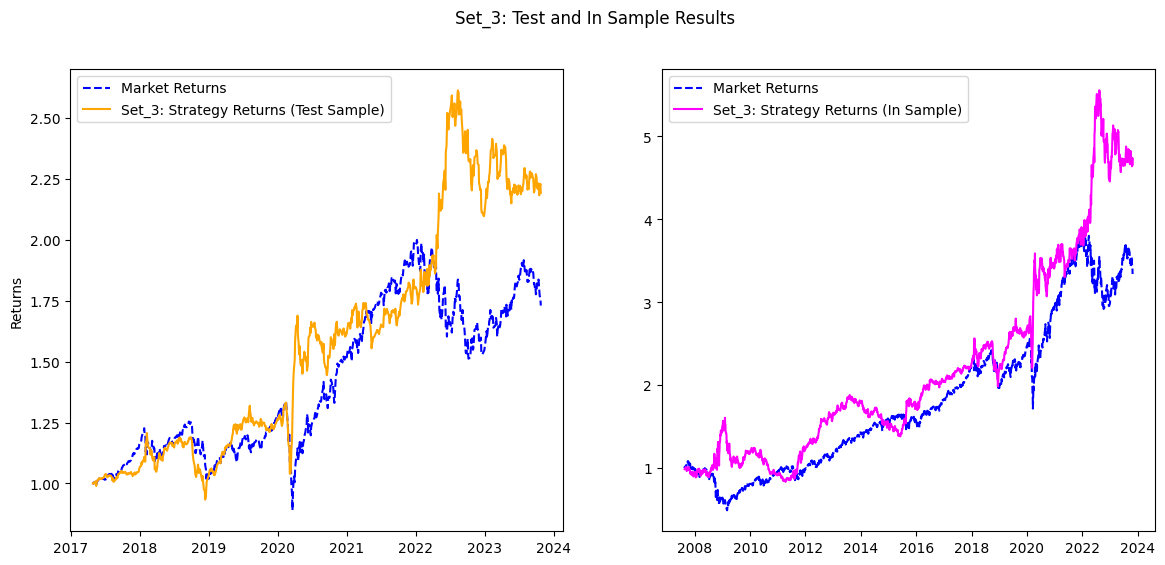

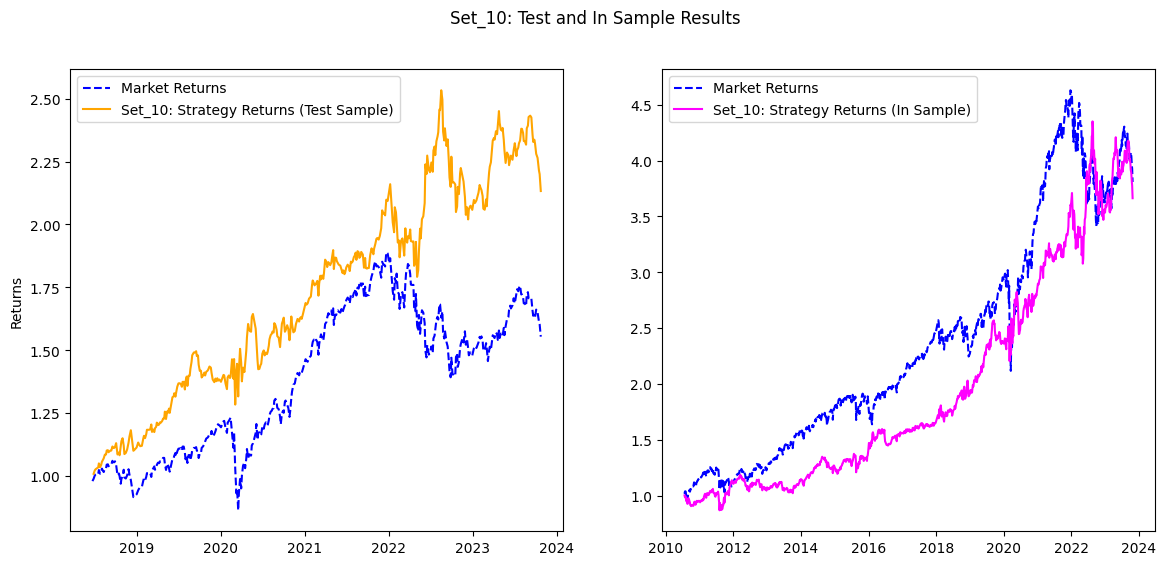

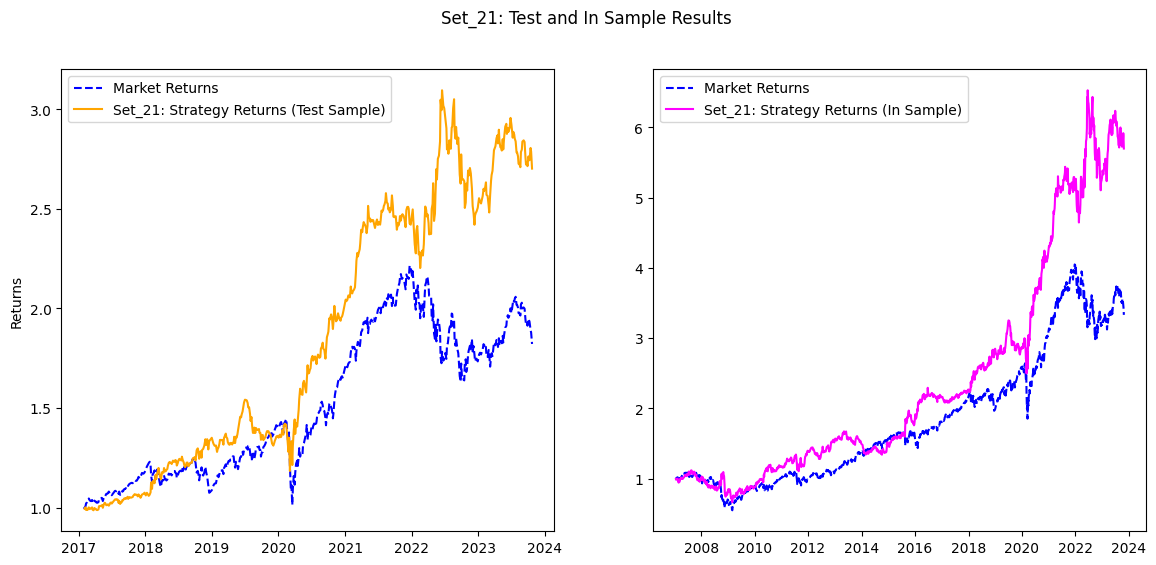

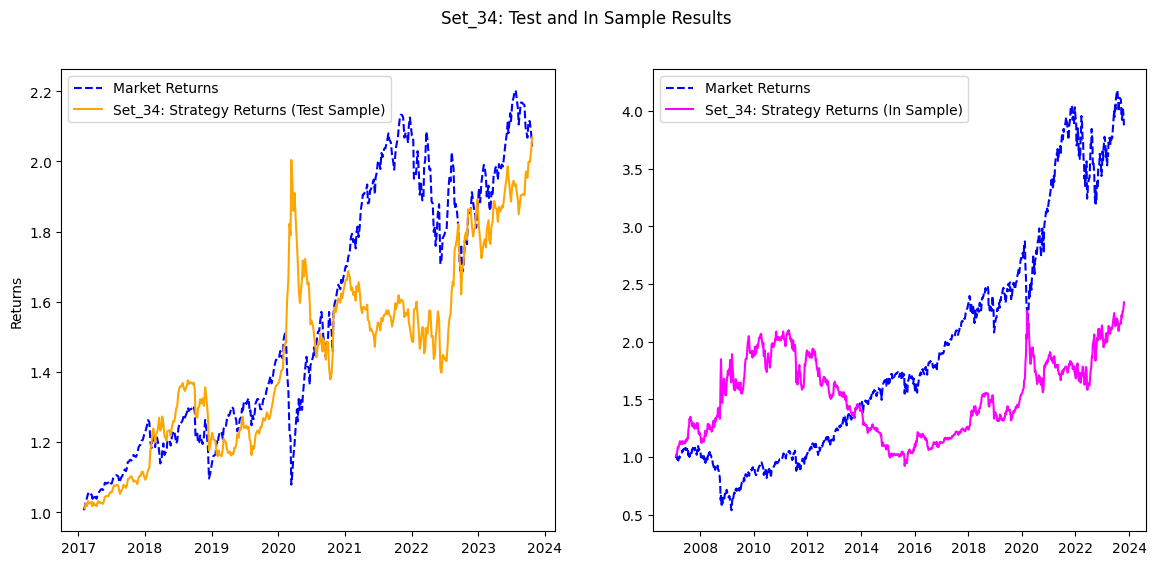

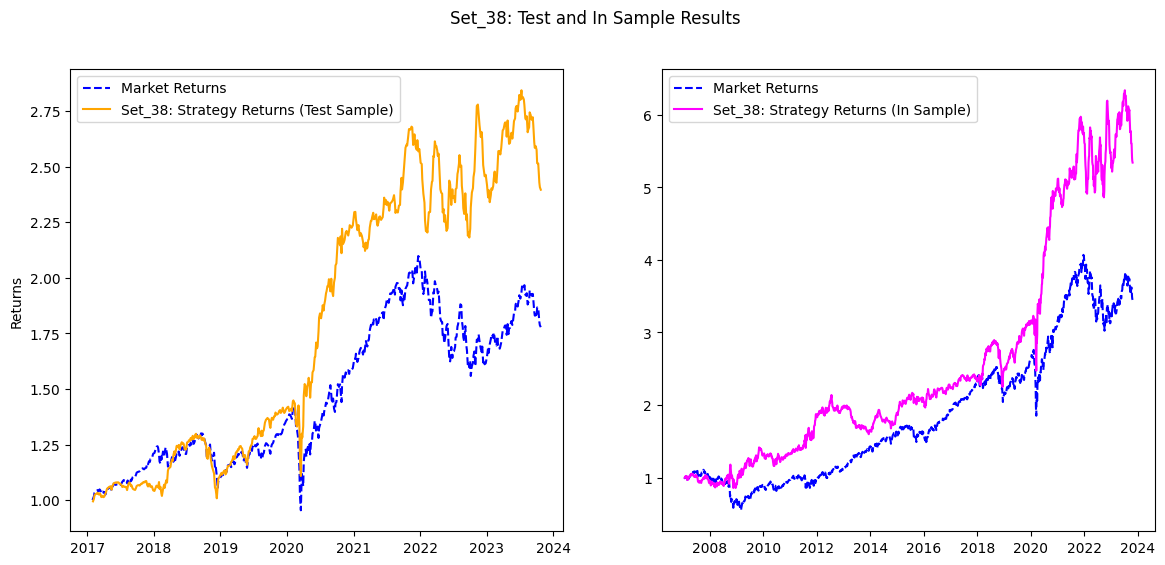

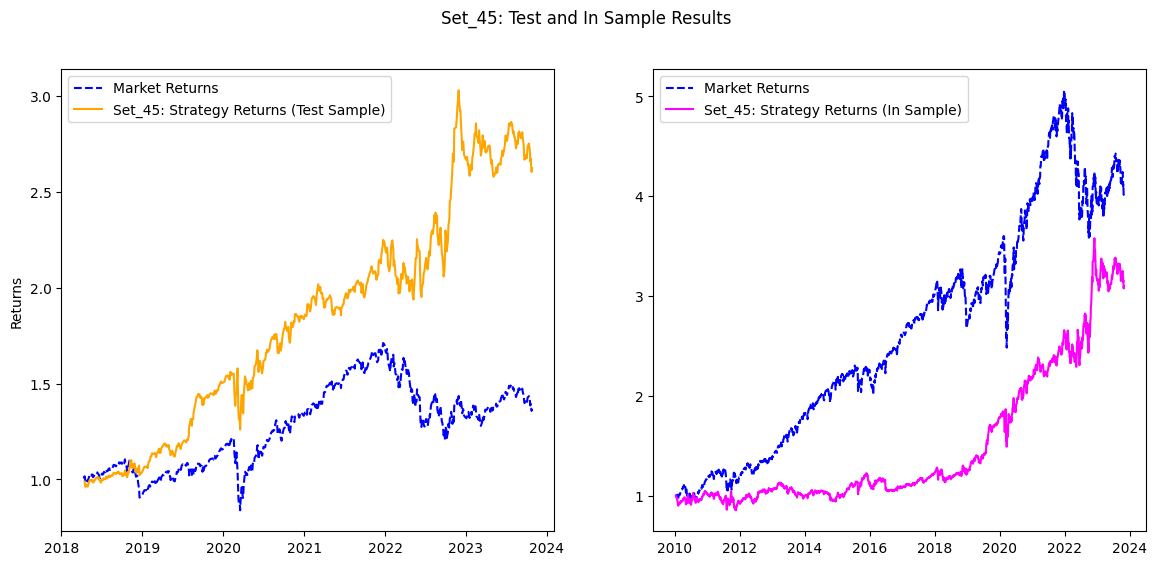

In [17]:
for set, (_, testsample, insample) in good_returns.items():
    fig, axs = plt.subplots(1, 2, figsize = (14,6))
    fig.suptitle(f"{set}: Test and In Sample Results")
    axs[0].plot(np.exp(testsample["Actual_Returns"]).cumprod(), "b--", label = "Market Returns")
    axs[0].plot(testsample["trend_Cummulative_Returns"], "orange", label = f"{set}: Strategy Returns (Test Sample)")
    axs[0].legend(loc="upper left")
    axs[0].set_ylabel("Returns")
    axs[1].plot(np.exp(insample["Actual_Returns"]).cumprod(), "b--", label = "Market Returns")
    axs[1].plot(insample["trend_Cummulative_Returns"], "magenta", label = f"{set}: Strategy Returns (In Sample)")
    axs[1].legend(loc="upper left")

### Performance Measurements

#### Max Drawdown Periods

In [18]:
def calculate_max_drawdown_periods(df, cum_returns_col):
    df["Max_Gross_Performance"] = df[cum_returns_col].cummax()
    df["Drawdown"] = df["Max_Gross_Performance"] - df[cum_returns_col]
    drawdowns = df[df["Drawdown"] == 0][["Drawdown"]]
    periods = pd.to_timedelta(drawdowns.index[1: ] - drawdowns.index[ :-1]).days.values
    
    max_dd = []
    start = drawdowns.index[0]
    end = drawdowns.index[0]
    
    for duration in periods:
        end += dt.timedelta(days = int(duration))
        max_pct = df["Drawdown"].loc[start:end].max()
        max_dd.append(max_pct*100)
        start += dt.timedelta(days = int(duration))
        
    drawdown_data = pd.concat([pd.Series(periods), pd.Series(max_dd)],
                                          axis = 1,
                                          keys = ["Drawdown Period", "Max Drawdown"]) \
                    .sort_values(by = "Max Drawdown",
                                 ascending = False,
                                 ignore_index = True)

    return drawdown_data

In [19]:
for set, (_, testsample, insample) in good_returns.items():
    
    drawdown_data_test_sample = calculate_max_drawdown_periods(testsample, "trend_Cummulative_Returns")
    print(f"{set} (Test Sample):\n {drawdown_data_test_sample.head()}")
    
    drawdown_data_in_sample = calculate_max_drawdown_periods(insample, "trend_Cummulative_Returns")
    print(f"{set} (In Sample):\n {drawdown_data_in_sample.head()}")

Set_3 (Test Sample):
    Drawdown Period  Max Drawdown
0               38     29.194919
1              457     27.298199
2              289     24.412199
3              199     18.582404
4               30     12.465840
Set_3 (In Sample):
    Drawdown Period  Max Drawdown
0             1367     77.127615
1               38     62.053119
2              457     58.021686
3              289     51.887558
4              944     49.635755
Set_10 (Test Sample):
    Drawdown Period  Max Drawdown
0              153     36.806768
1              229     21.954089
2              191     21.197821
3               30     12.922722
4              167      9.541655
Set_10 (In Sample):
    Drawdown Period  Max Drawdown
0              153     63.209639
1              229     37.702578
2              191     36.403811
3               30     22.192674
4              182     19.155819
Set_21 (Test Sample):
    Drawdown Period  Max Drawdown
0              259     37.607990
1              298     35.762878


#### Sharpe Ratio

In [20]:
def calculate_sharpe_ratio(ts_returns, periods_per_year = 252):
    n_years = ts_returns.shape[0] / periods_per_year
    annualized_return = np.power(np.prod(1 + ts_returns), (1 / n_years)
                                ) - 1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol
    return annualized_sharpe

In [21]:
for set, (_, testsample, insample) in good_returns.items():
    test_sample_sharpe = calculate_sharpe_ratio(np.exp(testsample["trend_Strategy_Returns"])-1)
    in_sample_sharpe = calculate_sharpe_ratio(np.exp(insample["trend_Strategy_Returns"])-1)   
    print(f"{set} Sharpe Ratio: {test_sample_sharpe:.3f} (Test Sample), {in_sample_sharpe:.3f} (In Sample)")

Set_3 Sharpe Ratio: 1.136 (Test Sample), 0.787 (In Sample)
Set_10 Sharpe Ratio: 1.637 (Test Sample), 1.248 (In Sample)
Set_21 Sharpe Ratio: 1.858 (Test Sample), 1.196 (In Sample)
Set_34 Sharpe Ratio: 1.697 (Test Sample), 0.647 (In Sample)
Set_38 Sharpe Ratio: 1.611 (Test Sample), 1.167 (In Sample)
Set_45 Sharpe Ratio: 1.640 (Test Sample), 0.809 (In Sample)


#### Remaining Cash

In [22]:
def get_remaining_cash(df, col, capital):
    return capital * df[col][-1]

In [23]:
initial = 1e5
for set, (_, testsample, insample) in good_returns.items():
    test_sample_cash = get_remaining_cash(testsample, "trend_Cummulative_Returns", initial)
    in_sample_cash = get_remaining_cash(insample, "trend_Cummulative_Returns", initial)
    print(f"{set} Account: {test_sample_cash:.2f} (Test Sample), {in_sample_cash:.2f} (In Sample)")

Set_3 Account: 219257.10 (Test Sample), 466025.84 (In Sample)
Set_10 Account: 213280.05 (Test Sample), 366273.81 (In Sample)
Set_21 Account: 270228.40 (Test Sample), 569825.93 (In Sample)
Set_34 Account: 206819.24 (Test Sample), 234107.91 (In Sample)
Set_38 Account: 239603.76 (Test Sample), 534172.10 (In Sample)
Set_45 Account: 262298.67 (Test Sample), 309800.46 (In Sample)


#### Compounded Annual Growth Rate

In [24]:
def calculate_CAGR(df, cum_returns_col):
    days = pd.to_timedelta(df.index[-1] - df.index[0]).days
    CAGR = (df[cum_returns_col][-1] ** (365.0/days)) - 1
    return CAGR*100

In [25]:
for set, (_, testsample, insample) in good_returns.items():
    test_sample_CAGR = calculate_CAGR(testsample, "trend_Cummulative_Returns")
    in_sample_CAGR = calculate_CAGR(insample, "trend_Cummulative_Returns")
    print(f"{set} CAGR: {test_sample_CAGR:.2f} (Test Sample), {in_sample_CAGR:.2f} (In Sample)")

Set_3 CAGR: 12.83 (Test Sample), 9.97 (In Sample)
Set_10 CAGR: 15.23 (Test Sample), 10.28 (In Sample)
Set_21 CAGR: 15.89 (Test Sample), 10.93 (In Sample)
Set_34 CAGR: 11.40 (Test Sample), 5.21 (In Sample)
Set_38 CAGR: 13.85 (Test Sample), 10.50 (In Sample)
Set_45 CAGR: 19.00 (Test Sample), 8.53 (In Sample)


### Best Model (Identified through multiple rounds of iterations)

> Results for best model (In Sample Backtesting)

- ARIMA final capital: $706,948.88
- ARIMA max drawdown: 111.24% over 445 days
- ARIMA sharpe ratio: 1.035
- ARIMA CAGR: 12.83%

In [17]:
for set in good_returns.keys():
    print(f"\n{set}:")
    print(f"{feature_set[set].get_currency_tickers()}\n"
          f"{feature_set[set].get_index_tickers()}\n"
          f"{feature_set[set].get_return_period()}\n"
          f"{feature_set[set].get_stock_tickers()}\n"
          f"{feature_set[set].get_window()}")


Set_0:
Index(['DEXKOUS', 'DEXUSEU'], dtype='object')
Index(['SHV', 'VTI', 'GLD'], dtype='object')
2
['SPY', 'AMT', 'BMY', 'VMW', 'GOOGL', 'AAPL']
[20, 50, 200]


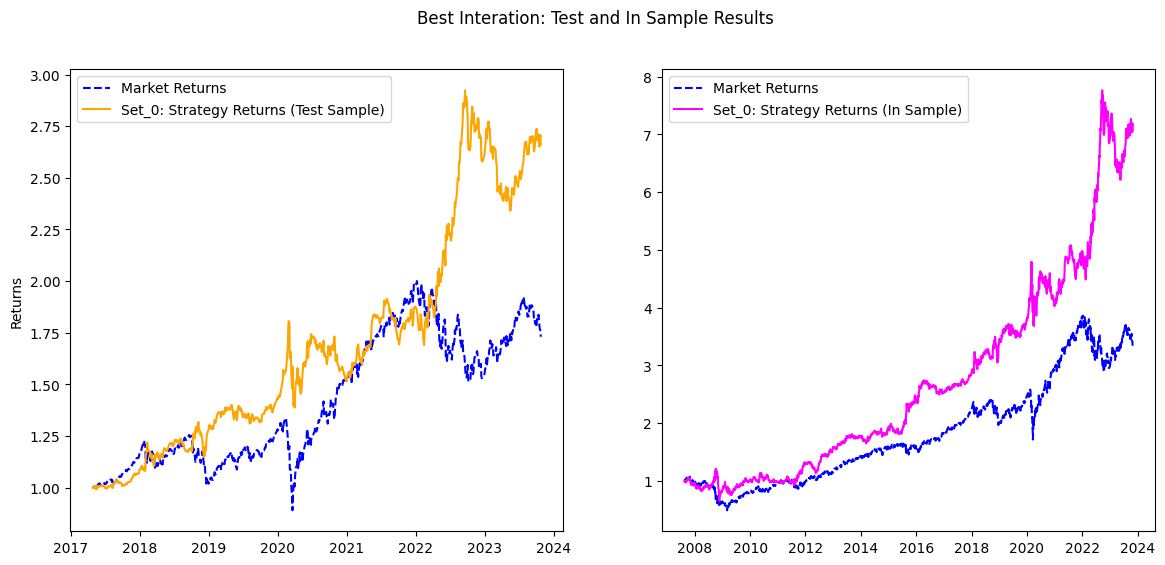

In [27]:
for set, (_, testsample, insample) in good_returns.items():
    fig, axs = plt.subplots(1, 2, figsize = (14,6))
    fig.suptitle(f"Best Interation: Test and In Sample Results")
    axs[0].plot(np.exp(testsample["Actual_Returns"]).cumprod(), "b--", label = "Market Returns")
    axs[0].plot(testsample["trend_Cummulative_Returns"], "orange", label = f"{set}: Strategy Returns (Test Sample)")
    axs[0].legend(loc="upper left")
    axs[0].set_ylabel("Returns")
    axs[1].plot(np.exp(insample["Actual_Returns"]).cumprod(), "b--", label = "Market Returns")
    axs[1].plot(insample["trend_Cummulative_Returns"], "magenta", label = f"{set}: Strategy Returns (In Sample)")
    axs[1].legend(loc="upper left")

In [20]:
for set, (_, testsample, insample) in good_returns.items():
    
    drawdown_data_test_sample = calculate_max_drawdown_periods(testsample, "trend_Cummulative_Returns")
    print(f"{set} (Test Sample):\n {drawdown_data_test_sample.head()}")
    
    drawdown_data_in_sample = calculate_max_drawdown_periods(insample, "trend_Cummulative_Returns")
    print(f"{set} (In Sample):\n {drawdown_data_in_sample.head()}")

Set_0 (Test Sample):
    Drawdown Period  Max Drawdown
0              445     41.887213
1              224     22.339640
2               86     16.866557
3              146     11.141868
4               37     10.830170
Set_0 (In Sample):
    Drawdown Period  Max Drawdown
0              445    111.236523
1              224     59.325596
2             1140     55.290497
3               86     44.791167
4              146     29.588567


In [22]:
for set, (_, testsample, insample) in good_returns.items():
    test_sample_sharpe = calculate_sharpe_ratio(np.exp(testsample["trend_Strategy_Returns"])-1)
    in_sample_sharpe = calculate_sharpe_ratio(np.exp(insample["trend_Strategy_Returns"])-1)   
    print(f"{set} Sharpe Ratio: {test_sample_sharpe:.3f} (Test Sample), {in_sample_sharpe:.3f} (In Sample)")

Set_0 Sharpe Ratio: 1.472 (Test Sample), 1.035 (In Sample)


In [24]:
initial = 1e5
for set, (_, testsample, insample) in good_returns.items():
    test_sample_cash = get_remaining_cash(testsample, "trend_Cummulative_Returns", initial)
    in_sample_cash = get_remaining_cash(insample, "trend_Cummulative_Returns", initial)
    print(f"{set} Account: {test_sample_cash:.2f} (Test Sample), {in_sample_cash:.2f} (In Sample)")

Set_0 Account: 266208.59 (Test Sample), 706948.88 (In Sample)


In [26]:
for set, (_, testsample, insample) in good_returns.items():
    test_sample_CAGR = calculate_CAGR(testsample, "trend_Cummulative_Returns")
    in_sample_CAGR = calculate_CAGR(insample, "trend_Cummulative_Returns")
    print(f"{set} CAGR: {test_sample_CAGR:.2f} (Test Sample), {in_sample_CAGR:.2f} (In Sample)")

Set_0 CAGR: 16.25 (Test Sample), 12.83 (In Sample)


## <font color = "blue">Supervised Learning</font>

### Set Up

In [2]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
def get_data_yf(tickers,start,end):
    return pd.DataFrame(yf.download(tickers,start,end).loc[:,'Adj Close'])

In [4]:
start = '2004-11-01'
end = '2023-10-31'

validation_size = 0.4
period = 5

In [5]:
spy = get_data_yf('SPY',start,end)

[*********************100%%**********************]  1 of 1 completed


In [6]:
stock_ticker = ['AMZN','AAPL','GOOGL','MSFT']
currency_ticker = ['DEXJPUS','DEXUSUK','DEXCAUS']
index_ticker1 = ["DIA",'^IXIC']
index_ticker2 = ["VIXCLS"]

In [7]:
stocks = pdr.get_data_yahoo(stock_ticker,start, end)
currencies = pdr.get_data_fred(currency_ticker,start, end)
indexes1 = pdr.get_data_yahoo(index_ticker1,start, end)
indexes2 = pdr.get_data_fred(index_ticker2,start, end)

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  2 of 2 completed


### Feature Selection and Model Training

In [8]:
indexes1 = indexes1[['Adj Close']]

In [9]:
indexes1.columns = indexes1.columns.droplevel()

In [10]:
indexes1 = indexes1.rename(columns={'Adj Close':'DIA'})

In [11]:
indexes = pd.concat([indexes1,indexes2],axis=1)

In [12]:
Y = \
(
    spy['Adj Close']
    .pct_change()
    .shift(-1)
)

In [14]:
X1 = \
(
    stocks.loc[:,'Adj Close']
    .pct_change()
)

In [15]:
X2 = \
(
    currencies
    .pct_change()
    
)

In [16]:
X3 = \
(
    indexes
        .pct_change()
)

In [18]:
X4 = \
(
    pd.concat([spy['Adj Close'
                  ]   
              .pct_change(x) for x in [period,
                                       period*3,
                                       period*6,
                                       period*12]
              ],
              axis=1
             )
    .dropna()
)
X4.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]

In [19]:
window = 21
span = 10

X5 = pd.DataFrame()
X5.index = spy['Adj Close'].index

for i in [window, window*3, window*12]:
    name = f"SMA{i}"
    X5[name] = spy['Adj Close'].rolling(i).mean().pct_change()
for i in [span, span*3, span*20]:
    name = f"EWM{i}"
    X5[name] = spy['Adj Close'].ewm(span=i,min_periods=i).mean().pct_change()

In [20]:
for i in [span, span*3, span*20]:
    name1 = f"%K_{i}"
    name2 = f"%D_{i}"
    spy[name1]=np.nan
    for j in range(i,len(spy)):
        spy[name1][j] = (
                (spy['Adj Close'][j] - spy['Adj Close'][j-i:j+1].min())
                /
                (spy['Adj Close'][j-i:j+1].max() - spy['Adj Close'][j-i:j+1].min())
            )
    spy[name2] = spy[name1].rolling(i).mean()
    X5[name1] = spy[name1]
    X5[name2] = spy[name2].pct_change()

In [21]:
def get_RSI(stock):
    stock['diff_1'] = stock['Adj Close'].diff()
    stock['rs_gain']=np.where(stock['diff_1']>0,stock['diff_1'],0)
    stock['rs_loss']=np.where(stock['diff_1']<0,stock['diff_1'],0)
    
    for window in [span,span*3,span*20]:
        column = f"RS{window}"
        name = f"RSI{window}"
        stock[column], stock[name] = np.nan,np.nan
        for i in range(len(stock)+1) :
            if i == window :
                stock[column][i-1] = stock['rs_gain'][:i].mean()/abs(stock['rs_loss'][:i]).mean()
            elif i > window :
                stock[column][i-1] = (
                                (stock['rs_gain'][i-15:i-1].mean()*window+stock['rs_gain'][i-1])/window
                                 /
                                ((abs(stock['rs_loss'][i-15:i-1]).mean()*window+abs(stock['rs_loss'][i-1]))/window)
                                  )
        stock[name] = 100 - 100/(1+stock[column])
        X5[name] = stock[name]
        X5[name] = np.log(X5[name]).pct_change()

In [22]:
get_RSI(spy)

In [23]:
X = \
(
    pd.concat([X1,X2,X3,X4,X5],
                axis = 1)
)

In [24]:
data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
)

In [25]:
data

Adj Close      AAPL      AMZN     GOOGL      MSFT   DEXJPUS  \
2006-06-05  -0.002439 -0.026922 -0.036536 -0.013177 -0.011424  0.000358   
2006-06-06  -0.007492 -0.004667 -0.002389  0.041529 -0.016444  0.013966   
2006-06-07  -0.000874 -0.019424  0.010775 -0.008923 -0.004067  0.000795   
2006-06-08  -0.003181  0.037569 -0.006515  0.017567  0.003176  0.007675   
2006-06-09  -0.010850 -0.025017  0.006855 -0.017112 -0.008593 -0.002889   
...               ...       ...       ...       ...       ...       ...   
2023-10-23   0.007539  0.000694  0.011105  0.006637  0.008112 -0.000467   
2023-10-24  -0.014352  0.002543  0.015803  0.016923  0.003674  0.000401   
2023-10-25  -0.011975 -0.013492 -0.055772 -0.095094  0.030678  0.000667   
2023-10-26  -0.004533 -0.024606 -0.014993 -0.026511 -0.037514  0.003335   
2023-10-27   0.011956  0.007969  0.068328 -0.000900  0.005856 -0.005584   

             DEXUSUK   DEXCAUS       DIA     ^IXIC  ...    EWM200     %K_10  \
2006-06-05 -0.001647  0.000909 -0.014864 -0.022434  ...  0.000078  0.509153   
2006-06-06 -0.009475  0.012624 -0.006324 -0.003153  ...  0.000052  0.428213   
2006-06-07 -0.001236 -0.002960 -0.007273 -0.005077  ... -0.000024  0.180170   
2006-06-08 -0.008609  0.010434 -0.001741 -0.003011  ... -0.000033  0.000000   
2006-06-09  0.000054 -0.014422 -0.001559 -0.004783  ... -0.000065  0.000000   
...              ...       ...       ...       ...  ...       ...       ...   
2023-10-23  0.006747 -0.001169 -0.005646  0.002659  ... -0.000074  0.000000   
2023-10-24 -0.005313  0.004972  0.006438  0.009336  ...  0.000001  0.199875   
2023-10-25 -0.002465  0.002037 -0.003289 -0.024251  ... -0.000142  0.000000   
2023-10-26 -0.002224  0.004211 -0.007659 -0.017597  ... -0.000258  0.000000   
2023-10-27  0.003137  0.002603 -0.011073  0.003763  ... -0.000299  0.000000   

               %D_10     %K_30     %D_30    %K_200    %D_200     RSI10  \
2006-06-05  0.087364  0.261751 -0.045624  0.661995 -0.000838 -0.016524   
2006-06-06  0.092910  0.220140 -0.045437  0.642944 -0.000942 -0.000716   
2006-06-07  0.035769  0.092624 -0.042860  0.584561 -0.001287 -0.015734   
2006-06-08 -0.025972  0.077853 -0.044179  0.577798 -0.001313  0.044486   
2006-06-09 -0.087157  0.024163 -0.068814  0.553217 -0.001341  0.002146   
...              ...       ...       ...       ...       ...       ...   
2023-10-23 -0.140861  0.000000 -0.063008  0.558813  0.002037  0.007179   
2023-10-24 -0.131186  0.111947 -0.040331  0.566284  0.001525  0.064258   
2023-10-25 -0.188713  0.000000 -0.062713  0.485272  0.001016 -0.072890   
2023-10-26 -0.190604  0.000000 -0.124819  0.418651  0.000414 -0.023505   
2023-10-27 -0.193347  0.000000 -0.087619  0.393735 -0.000061 -0.058611   

               RSI30    RSI200  
2006-06-05  0.016724  0.032015  
2006-06-06 -0.023883 -0.034232  
2006-06-07 -0.006679 -0.002663  
2006-06-08  0.031998  0.026574  
2006-06-09  0.006924  0.008997  
...              ...       ...  
2023-10-23 -0.017687 -0.028785  
2023-10-24  0.043155  0.033083  
2023-10-25 -0.026221 -0.003534  
2023-10-26 -0.031124 -0.034770  
2023-10-27 -0.072175 -0.078298  

[4381 rows x 30 columns]

In [26]:
Y = data.loc[ : , Y.name]
X = data.loc[ : , X.columns]

In [27]:
train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

In [28]:
num_folds = 10
seed = 231119
scoring = "neg_mean_squared_error"

In [39]:
models = []

In [40]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )
models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )
models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [42]:
names = []
kfold_results = []
train_results = []
test_results = []

for name, model in models:
    names.append(name)

    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring,
                        error_score='raise')
        )

    kfold_results.append(cv_results)

    res = model.fit(X_train, Y_train)

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    
    train_results.append(train_result)

    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)

    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result, 
                                     test_result)
    print(message)

LR: 0.000174 (0.000043) 0.000162 0.000148
LASSO: 0.000167 (0.000043) 0.000167 0.000144
EN: 0.000167 (0.000043) 0.000167 0.000144
CART: 0.000348 (0.000043) 0.000000 0.000283
KNN: 0.000200 (0.000041) 0.000132 0.000167
SVR: 0.000327 (0.000135) 0.000314 0.000291
RFR: 0.000187 (0.000041) 0.000025 0.000144
ETR: 0.000190 (0.000038) 0.000000 0.000147
GBR: 0.000198 (0.000041) 0.000090 0.000145
ABR: 0.000175 (0.000033) 0.000128 0.000145


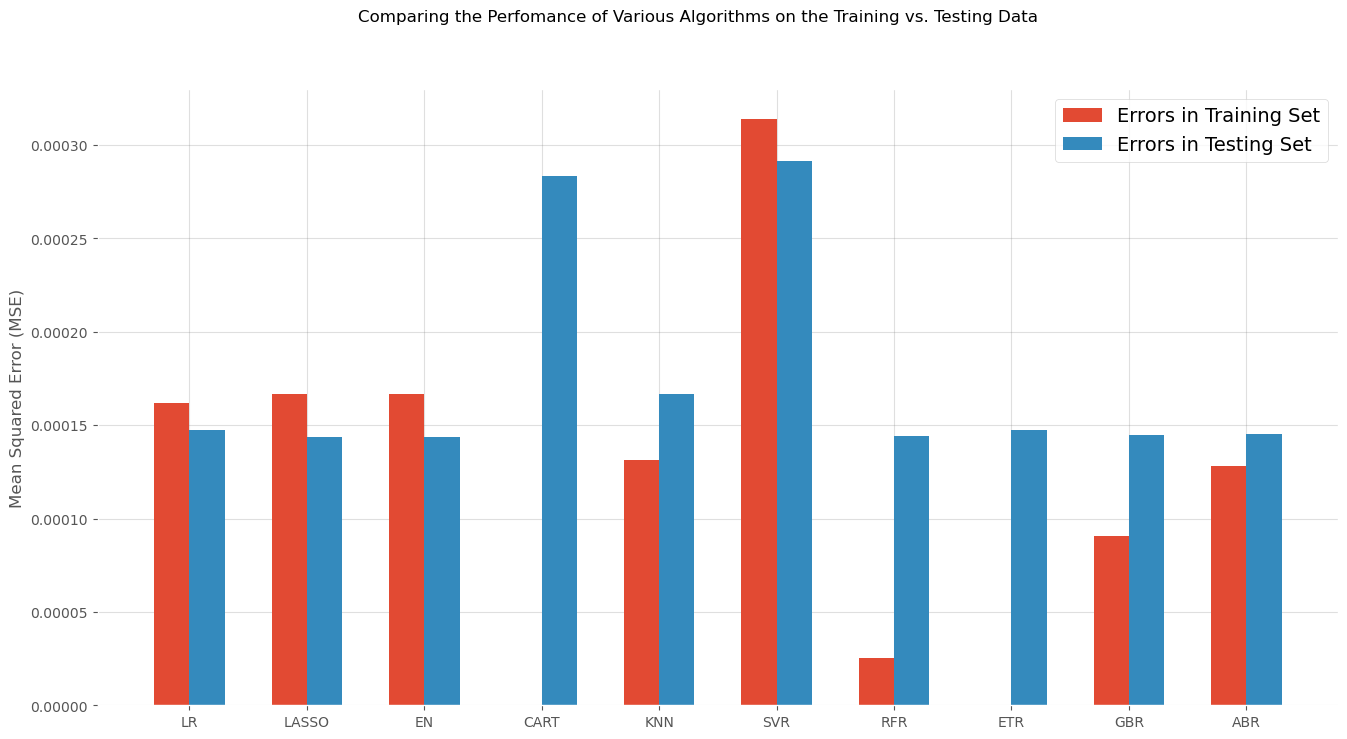

In [43]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
    
      # Team, this line calculates the starting x position of the bars 
      # representing "Errors in Training Set". 
      # The width/2 term is used to shift the bars to the left, 
      # so they are centered around the tick mark for each group (algorithm) on the x-axis.
      
      # The bar chart will have two sets of bars for each algorithm: 
      # one for training errors and one for testing errors. 
      
      # By subtracting width/2 from ind, 
      # the training error bars are positioned to the left of the center of the tick marks. 
      
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

### Backtesting

In [44]:
models

[('LR', LinearRegression()),
 ('LASSO', Lasso()),
 ('EN', ElasticNet()),
 ('CART', DecisionTreeRegressor()),
 ('KNN', KNeighborsRegressor()),
 ('SVR', SVR()),
 ('RFR', RandomForestRegressor()),
 ('ETR', ExtraTreesRegressor()),
 ('GBR', GradientBoostingRegressor()),
 ('ABR', AdaBoostRegressor())]

In [45]:
data.head()

Adj Close      AAPL      AMZN     GOOGL      MSFT   DEXJPUS  \
2006-06-05  -0.002439 -0.026922 -0.036536 -0.013177 -0.011424  0.000358   
2006-06-06  -0.007492 -0.004667 -0.002389  0.041529 -0.016444  0.013966   
2006-06-07  -0.000874 -0.019424  0.010775 -0.008923 -0.004067  0.000795   
2006-06-08  -0.003181  0.037569 -0.006515  0.017567  0.003176  0.007675   
2006-06-09  -0.010850 -0.025017  0.006855 -0.017112 -0.008593 -0.002889   

             DEXUSUK   DEXCAUS       DIA     ^IXIC  ...    EWM200     %K_10  \
2006-06-05 -0.001647  0.000909 -0.014864 -0.022434  ...  0.000078  0.509153   
2006-06-06 -0.009475  0.012624 -0.006324 -0.003153  ...  0.000052  0.428213   
2006-06-07 -0.001236 -0.002960 -0.007273 -0.005077  ... -0.000024  0.180170   
2006-06-08 -0.008609  0.010434 -0.001741 -0.003011  ... -0.000033  0.000000   
2006-06-09  0.000054 -0.014422 -0.001559 -0.004783  ... -0.000065  0.000000   

               %D_10     %K_30     %D_30    %K_200    %D_200     RSI10  \
2006-06-05  0.087364  0.261751 -0.045624  0.661995 -0.000838 -0.016524   
2006-06-06  0.092910  0.220140 -0.045437  0.642944 -0.000942 -0.000716   
2006-06-07  0.035769  0.092624 -0.042860  0.584561 -0.001287 -0.015734   
2006-06-08 -0.025972  0.077853 -0.044179  0.577798 -0.001313  0.044486   
2006-06-09 -0.087157  0.024163 -0.068814  0.553217 -0.001341  0.002146   

               RSI30    RSI200  
2006-06-05  0.016724  0.032015  
2006-06-06 -0.023883 -0.034232  
2006-06-07 -0.006679 -0.002663  
2006-06-08  0.031998  0.026574  
2006-06-09  0.006924  0.008997  

[5 rows x 30 columns]

In [46]:
origin_intestperiod = spy[['Adj Close']][spy.index>'2005-06-06']
origin_intestperiod = origin_intestperiod.iloc[train_size:,]
origin_intestperiod['log return']=\
(
     np.log(origin_intestperiod['Adj Close']
            /
            origin_intestperiod['Adj Close'].shift()
           )
)

In [51]:
def backtesting(models,initial_capital):
    for name,model in models:
        origin_intestperiod = spy[['Adj Close']][spy.index>'2006-06-04']
        origin_intestperiod = origin_intestperiod.iloc[train_size:,]
        origin_intestperiod['log return']=\
        (
             np.log(origin_intestperiod['Adj Close']
                    /
                    origin_intestperiod['Adj Close'].shift()
                   )
        )
        position = f"{name}_position"
        strategy = f"{name}_strategy"
        capital = f"{name}_capital"
        cumulative = f"{name}_cumulative"
        grossperformance = f"{name}_grossperformance"
        maxdrawdown = f"{name}_maxdrawdown"
        origin_intestperiod[position] = 0
        origin_intestperiod[position].iloc[:-1] = np.sign(model.predict(X_test))

        origin_intestperiod[strategy]=\
            origin_intestperiod['log return'] * origin_intestperiod[position].shift(1)
        
        
        origin_intestperiod[capital] = initial_capital
        
        origin_intestperiod.dropna(inplace=True)
        days = (origin_intestperiod.index[-1] - origin_intestperiod.index[0]).days
        for i in range(len(origin_intestperiod)) :
            origin_intestperiod[capital][i] = \
                origin_intestperiod[capital][i-1] * (origin_intestperiod[strategy].apply(np.exp)[i])
            
        origin_intestperiod[cumulative] = origin_intestperiod[capital]/initial_capital
        origin_intestperiod[grossperformance] = origin_intestperiod[cumulative].cumsum()
        drawdown = (origin_intestperiod[grossperformance] - origin_intestperiod[cumulative]).max()
        sharpe_ratio = \
            np.sqrt(253)*(
                            (origin_intestperiod[capital]/origin_intestperiod[capital].shift(1)-1).mean()
                            /
                            (origin_intestperiod[capital] / origin_intestperiod[capital].shift(1)-1).std()
                         )
        CAGR = \
        (
            (origin_intestperiod[cumulative][-1]/1)**(365 / days) -1
        )*100
        print(f"{name} final capital: {origin_intestperiod[capital][-1]}")
        print(f"{name} max drawdown: {drawdown}")
        print(f"{name} shapre ratio: {sharpe_ratio}")
        print(f"{name} CAGR : {CAGR}")
        print()
        plt.figure(figsize=(18,12))
        plt.title(name)
        plt.plot(origin_intestperiod.index,origin_intestperiod[cumulative])
        plt.plot(np.log(origin_intestperiod['Adj Close']
                        /
                        origin_intestperiod['Adj Close'].shift(1)).cumsum().apply(np.exp))

LR final capital: 132538.8671965218
LR max drawdown: 2060.773031706613
LR shapre ratio: 0.3105556892475225
LR CAGR : 4.122906381146008

LASSO final capital: 216895.50130729374
LASSO max drawdown: 2931.718815938017
LASSO shapre ratio: 0.6801885876881616
LASSO CAGR : 11.744083476208477

EN final capital: 216895.50130729374
EN max drawdown: 2931.718815938017
EN shapre ratio: 0.6801885876881616
EN CAGR : 11.744083476208477

CART final capital: 60618.678295192454
CART max drawdown: 1769.9828618671045
CART shapre ratio: -0.2818778191763103
CART CAGR : -6.927420171274923

KNN final capital: 108786.2354411839
KNN max drawdown: 2169.1927234902078
KNN shapre ratio: 0.15738355238214358
KNN CAGR : 1.2151165655364116

SVR final capital: 216895.50130729374
SVR max drawdown: 2931.718815938017
SVR shapre ratio: 0.6801885876881616
SVR CAGR : 11.744083476208477

RFR final capital: 373659.5959288722
RFR max drawdown: 3882.6037551706327
RFR shapre ratio: 1.0890995699748052
RFR CAGR : 20.810213186711103

E

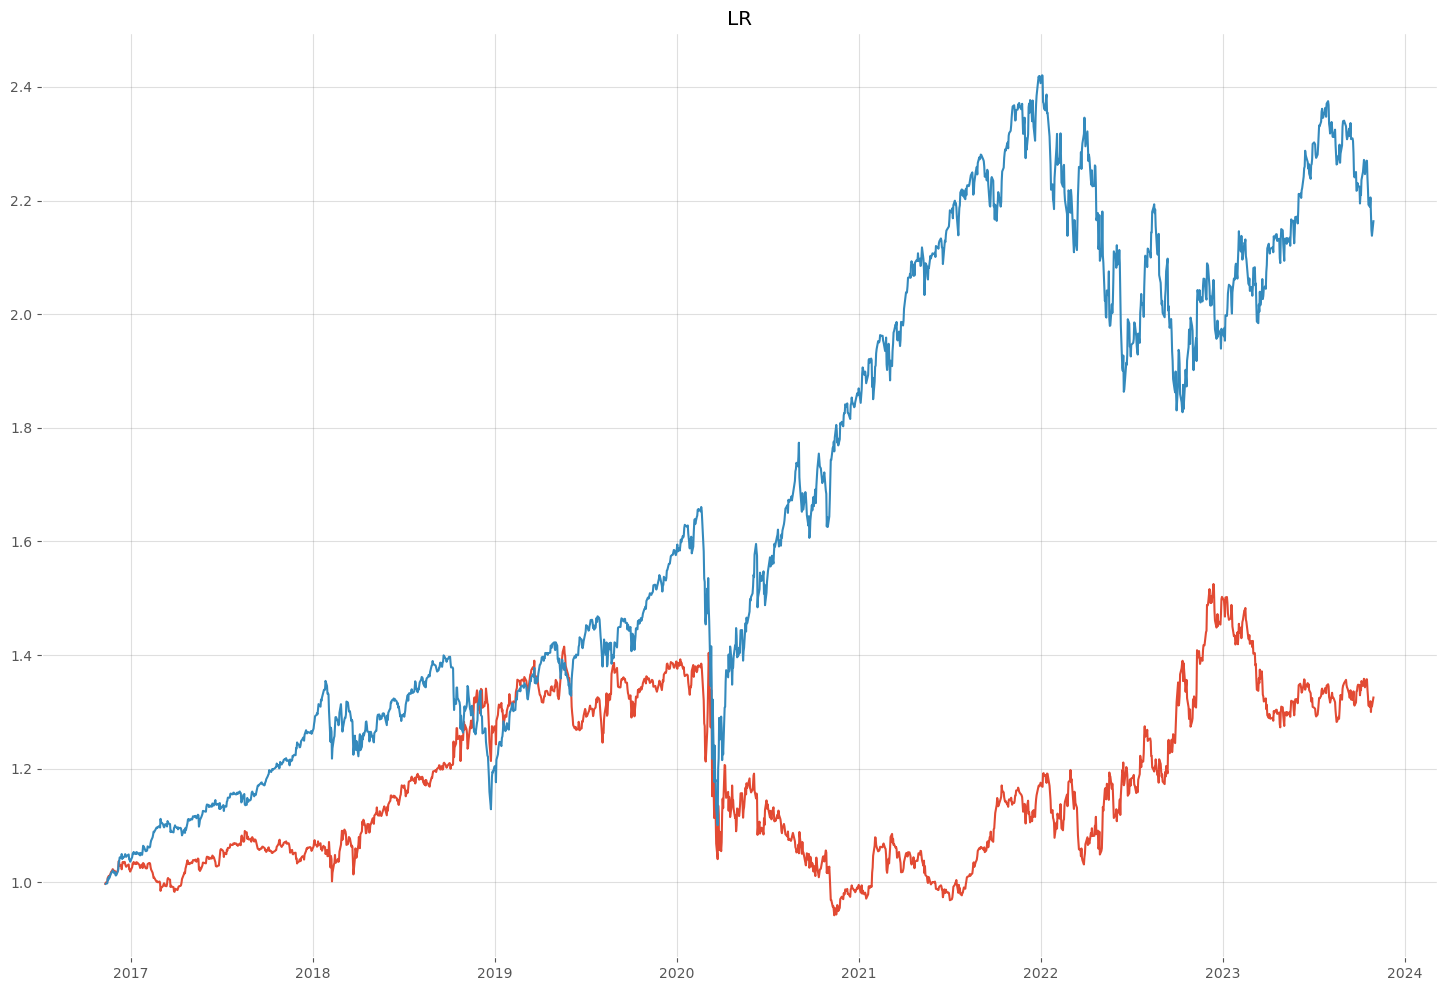

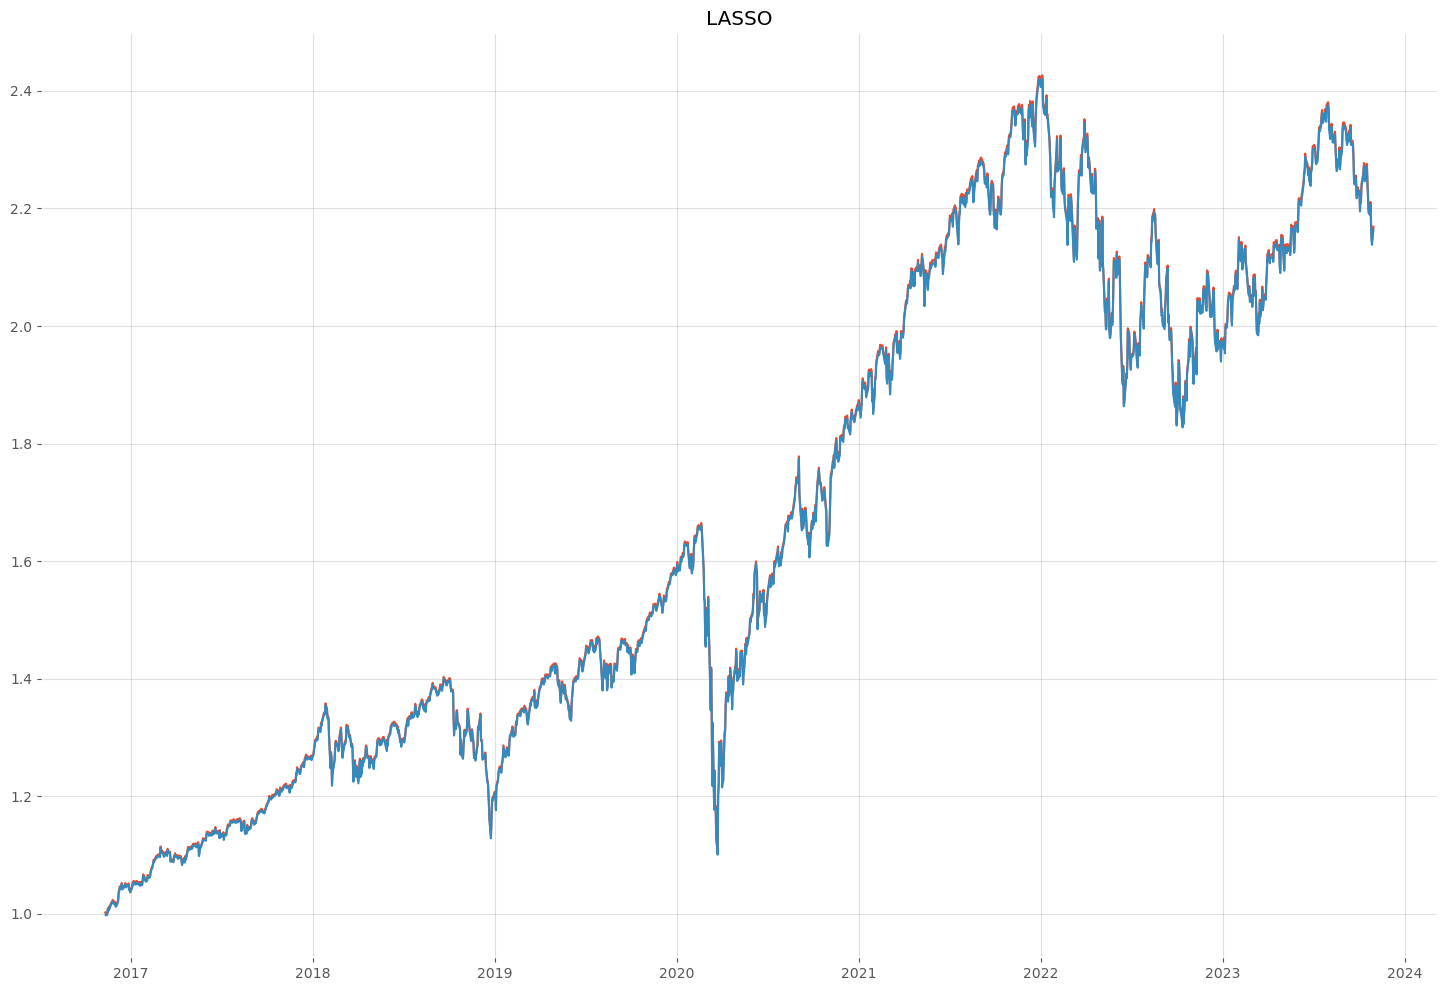

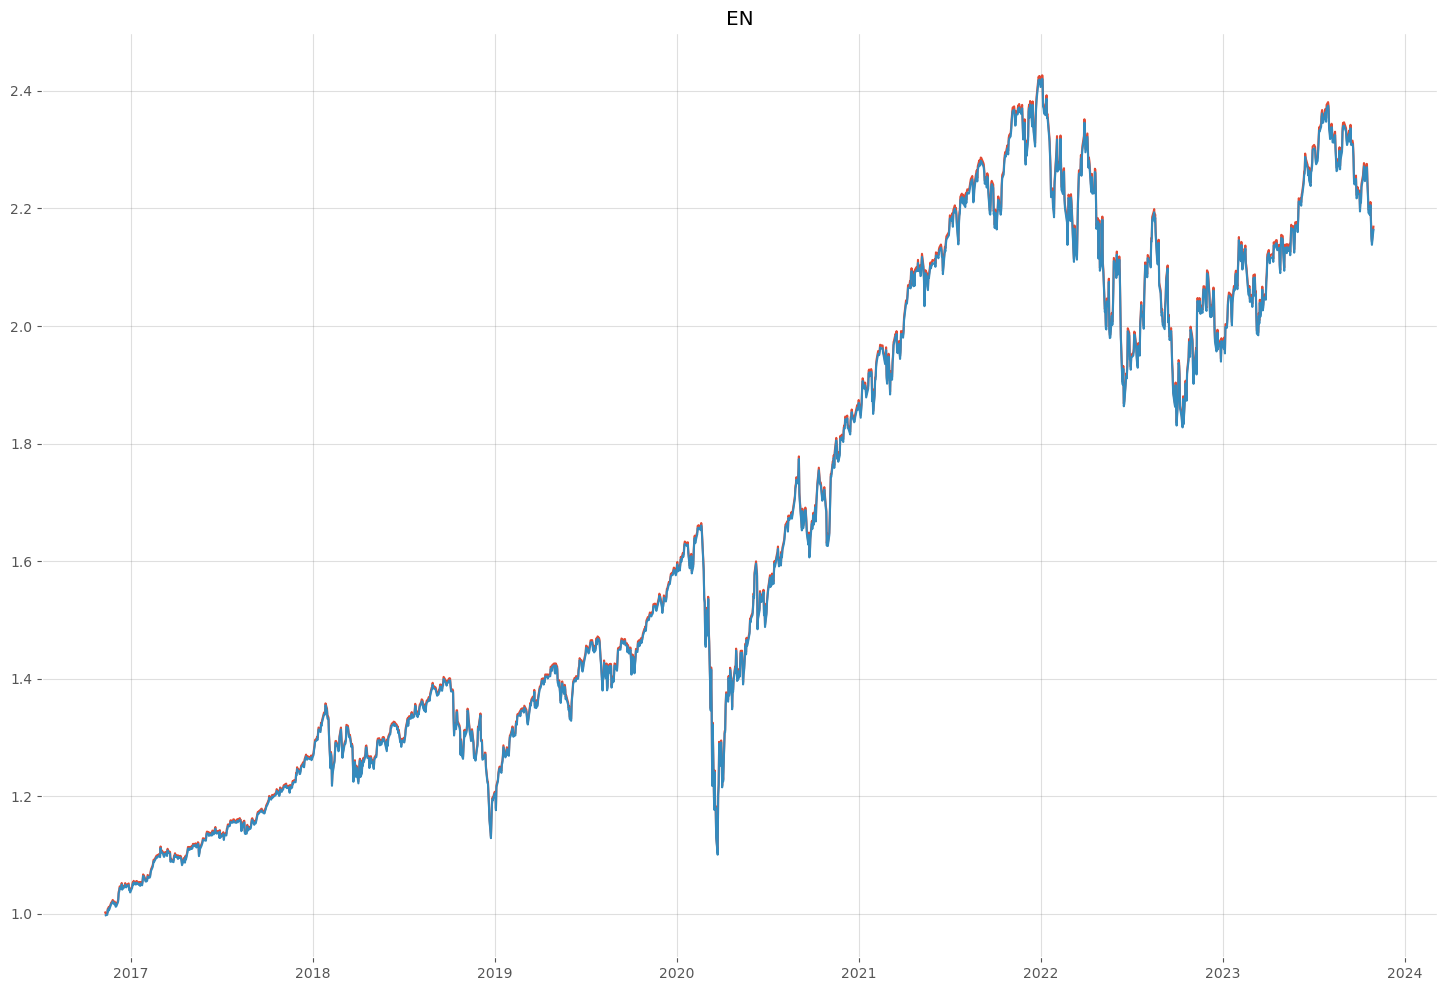

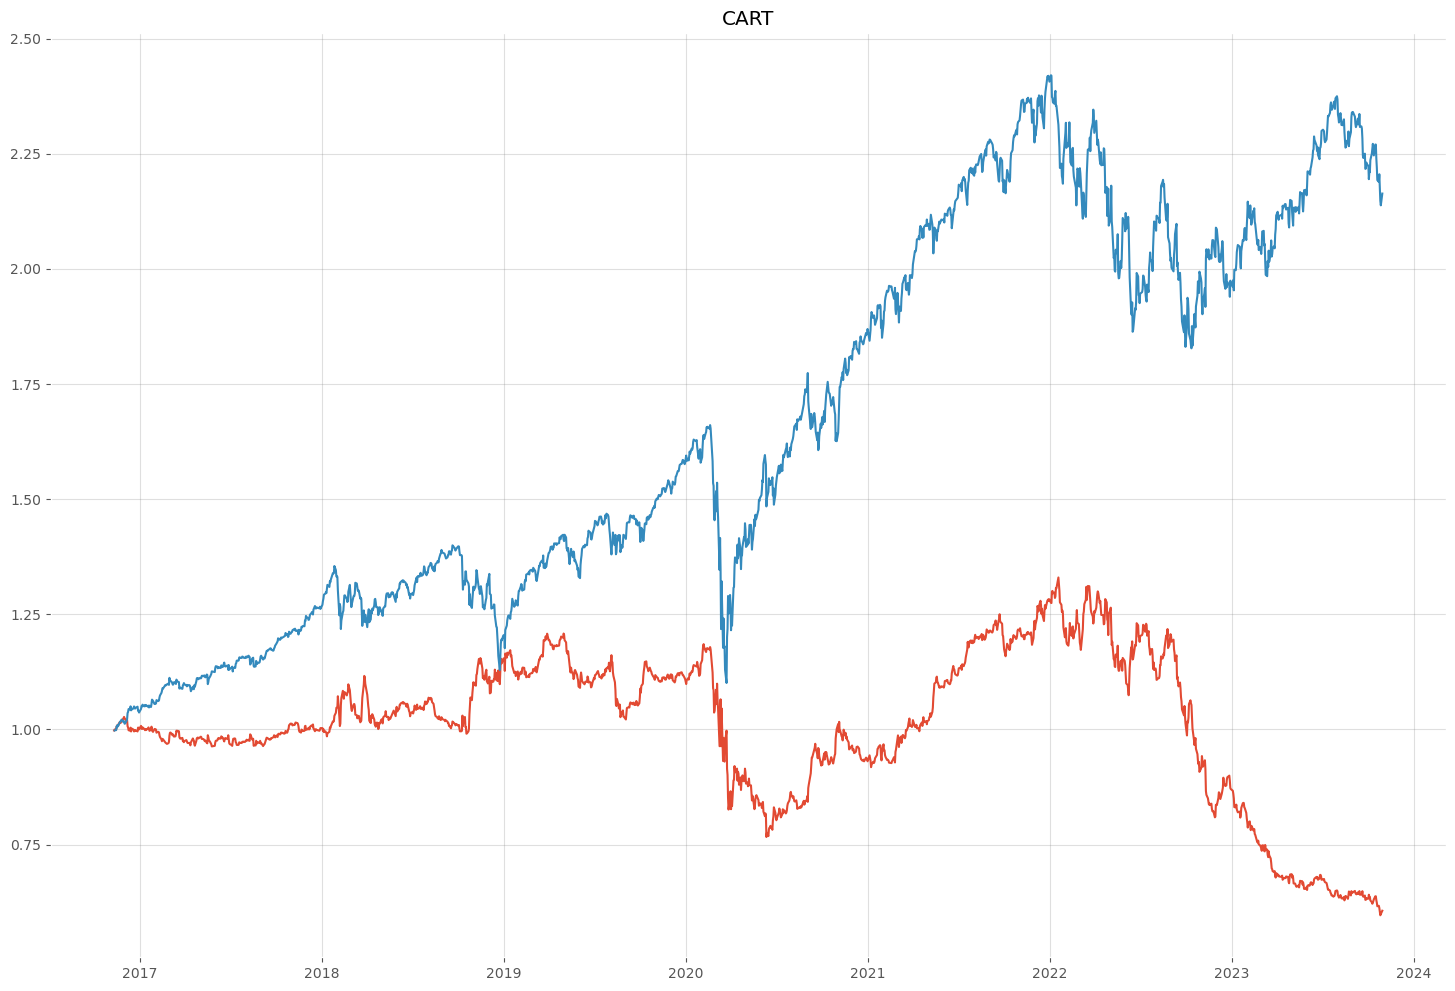

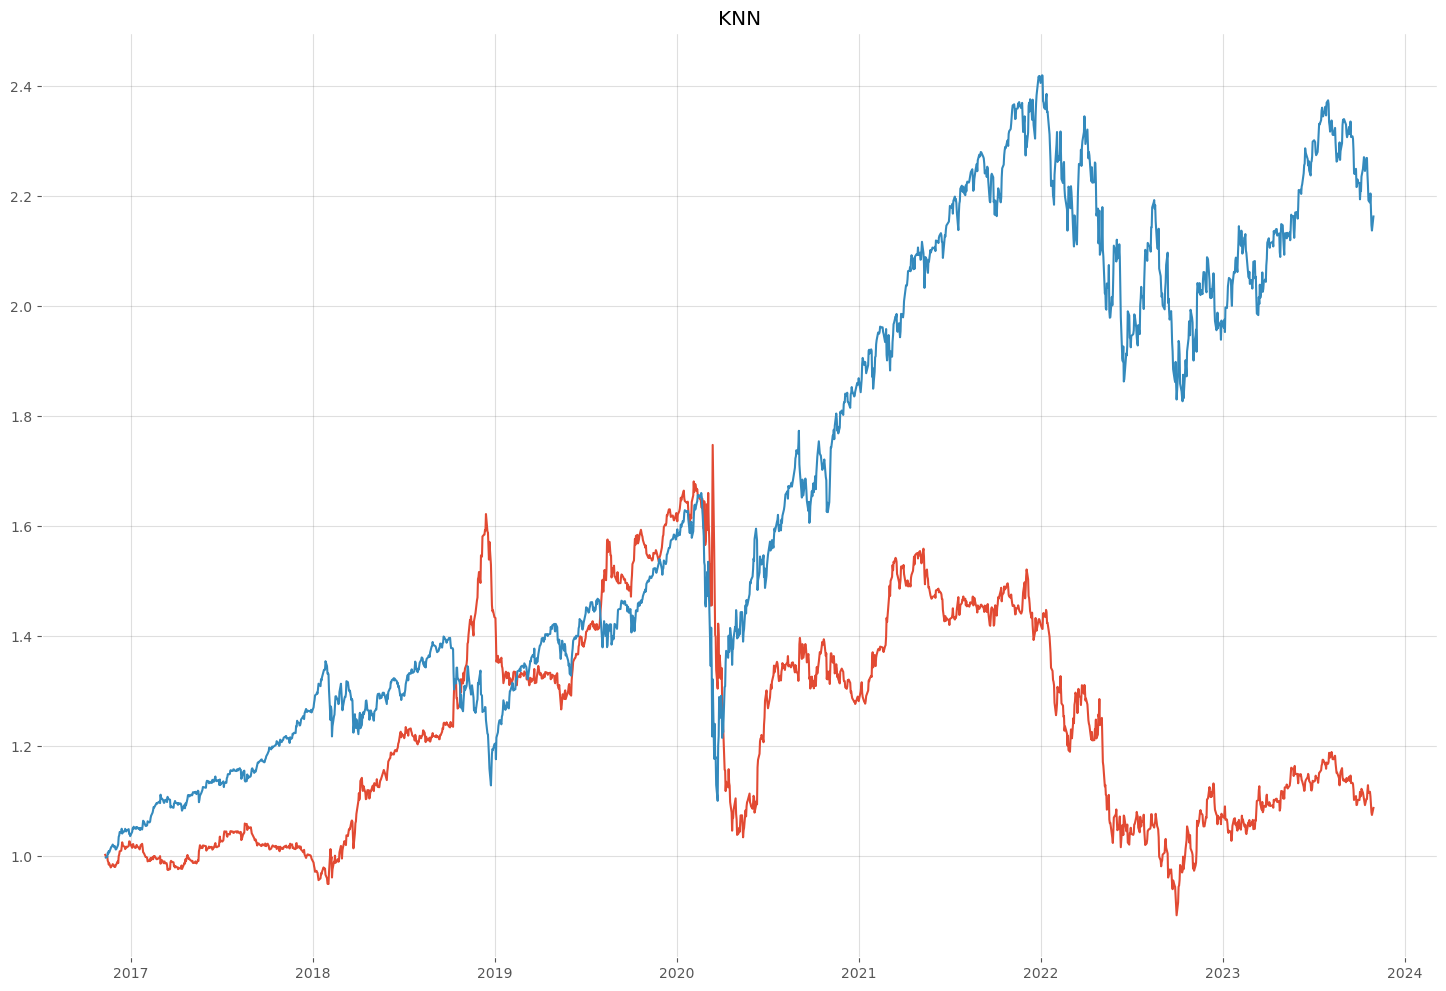

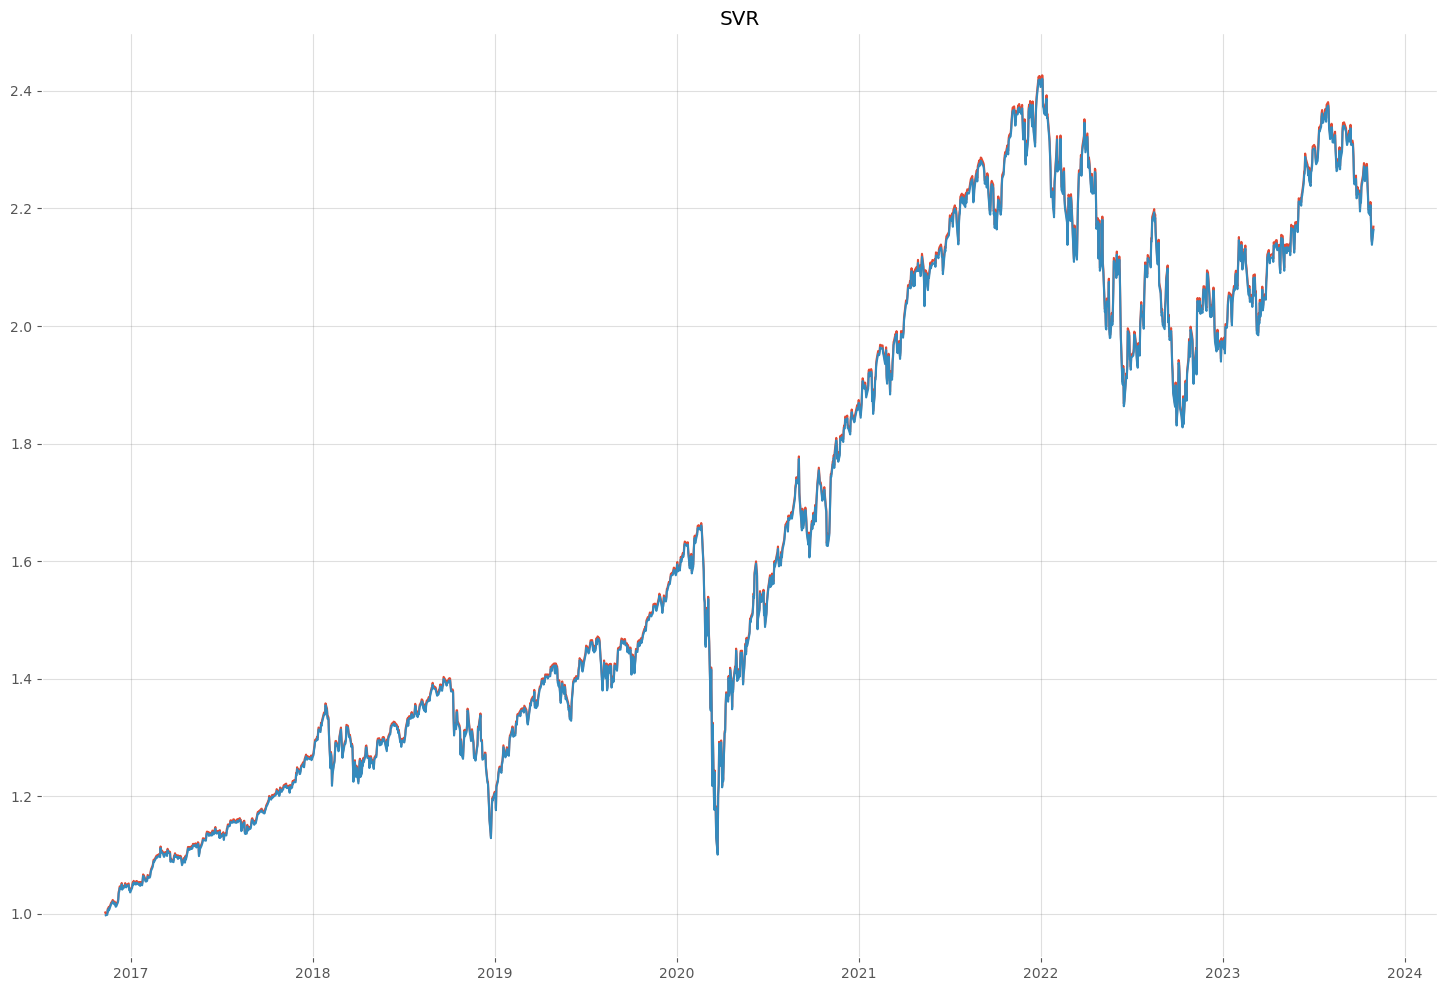

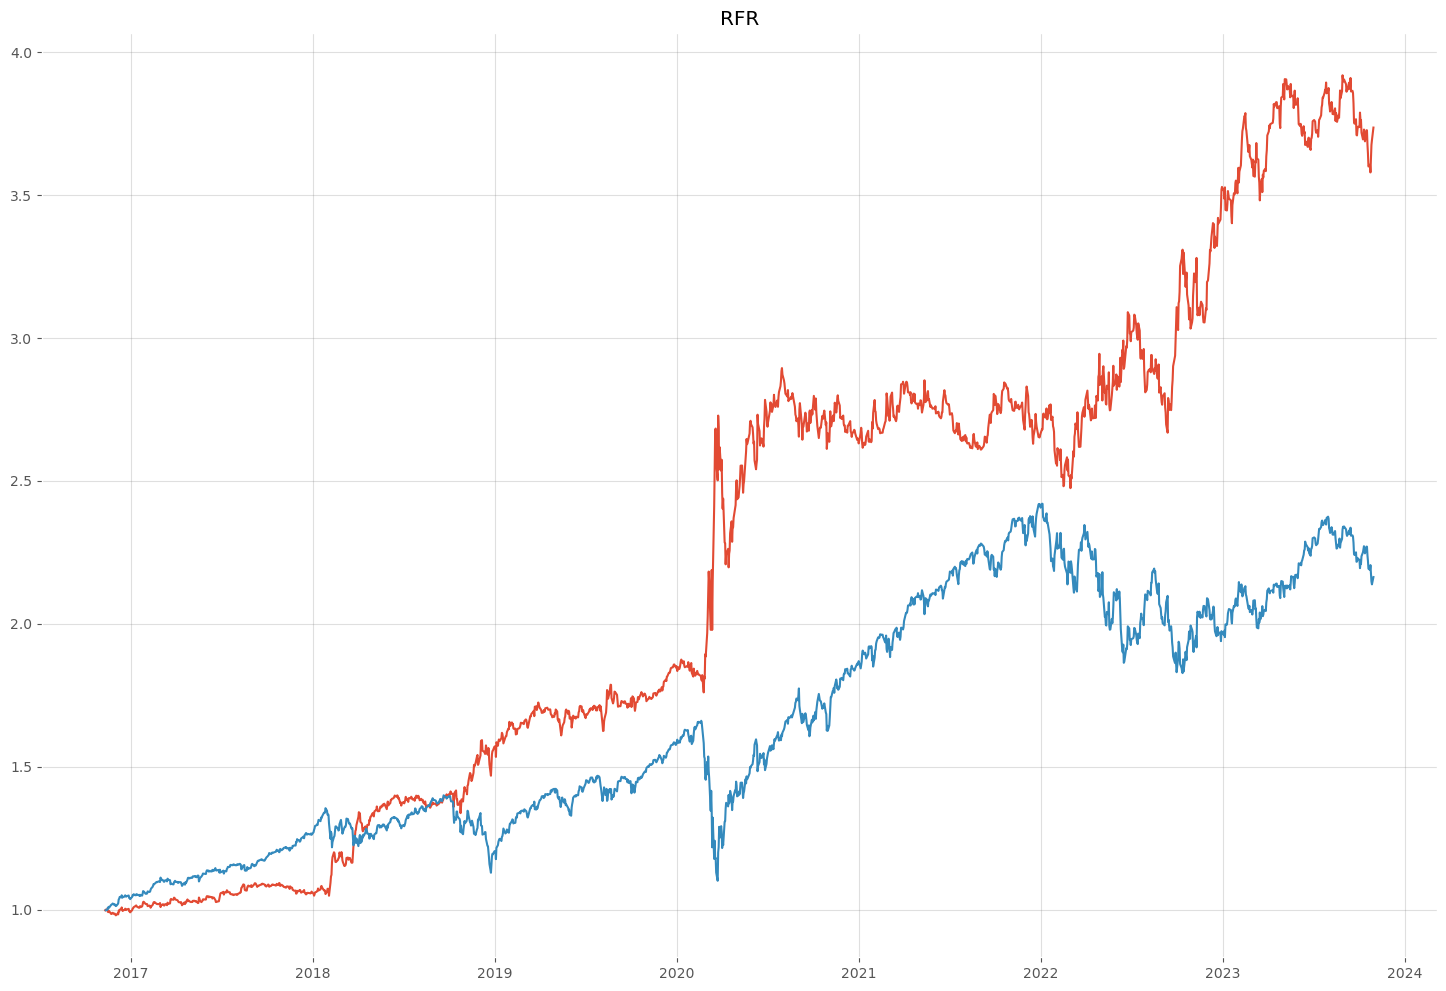

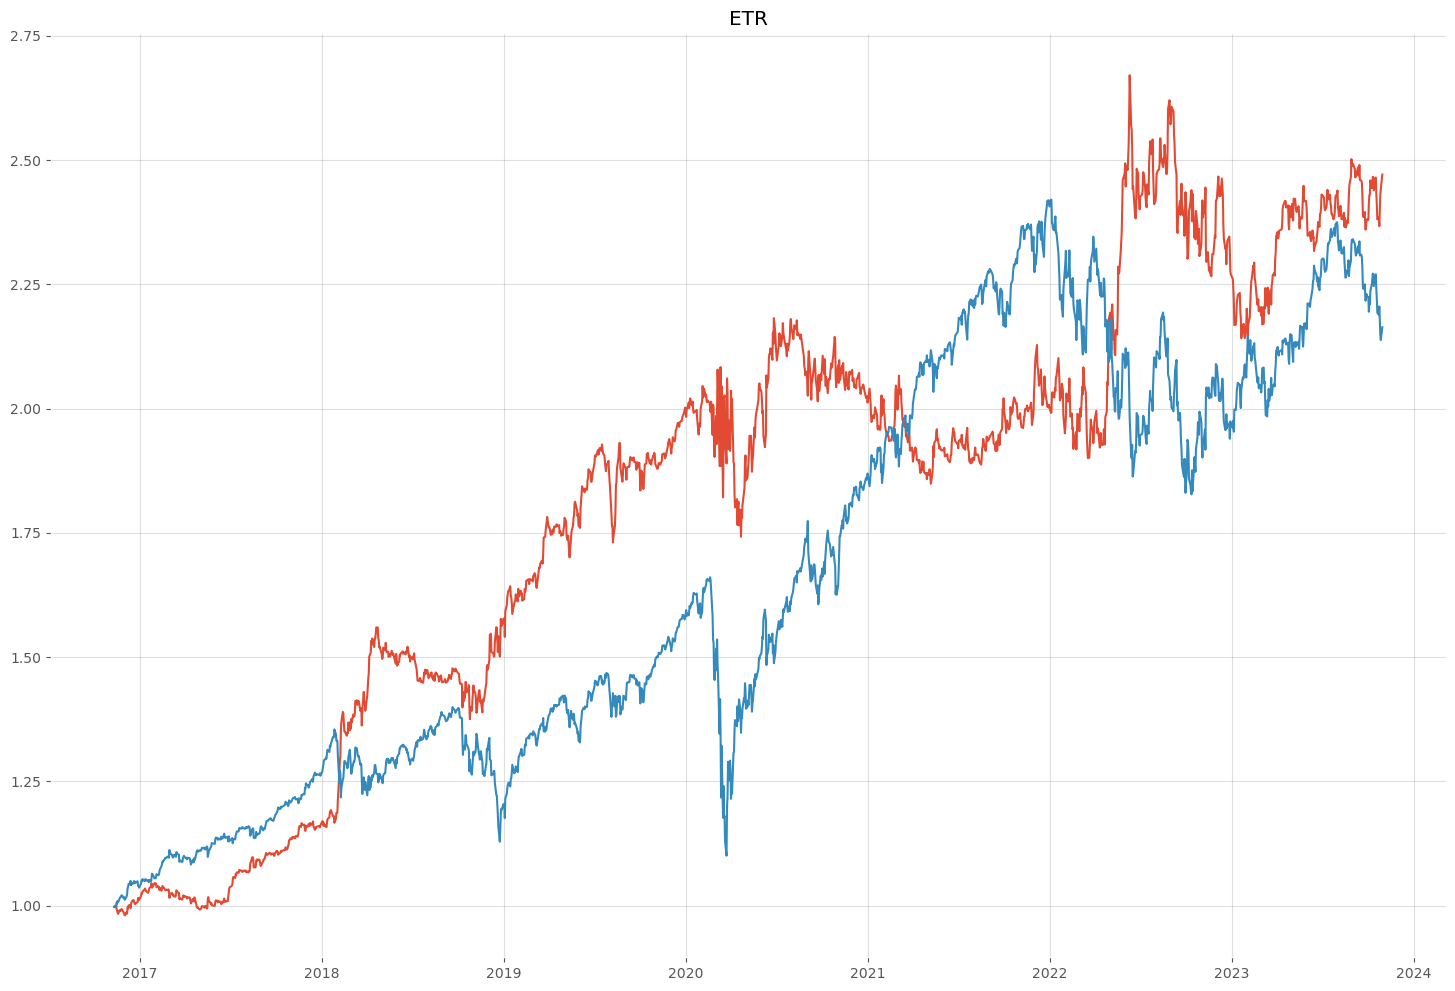

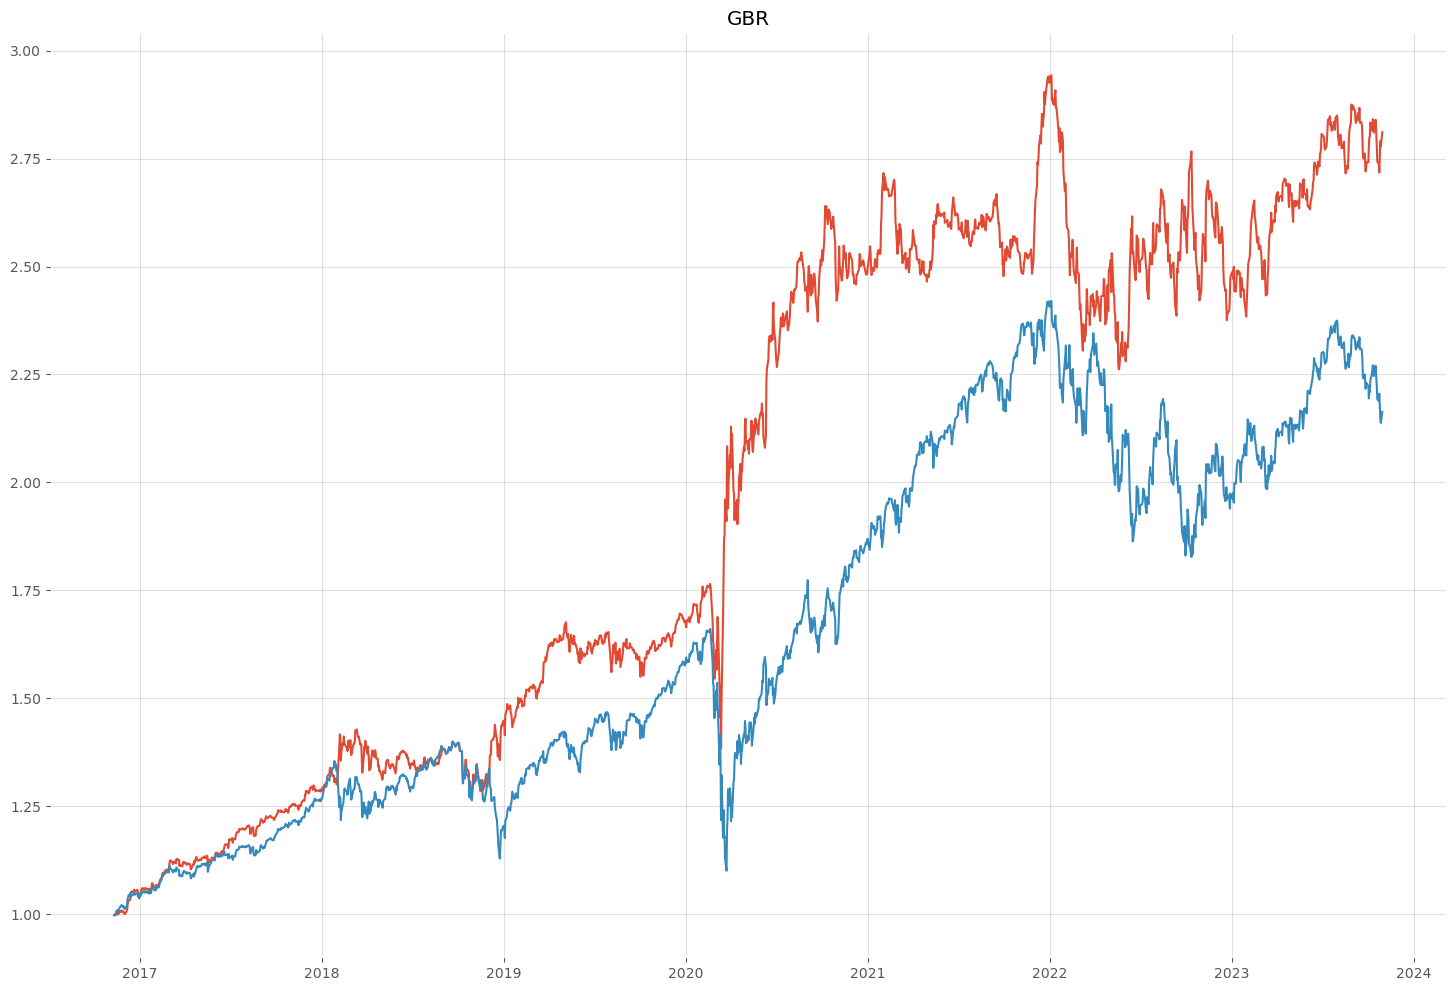

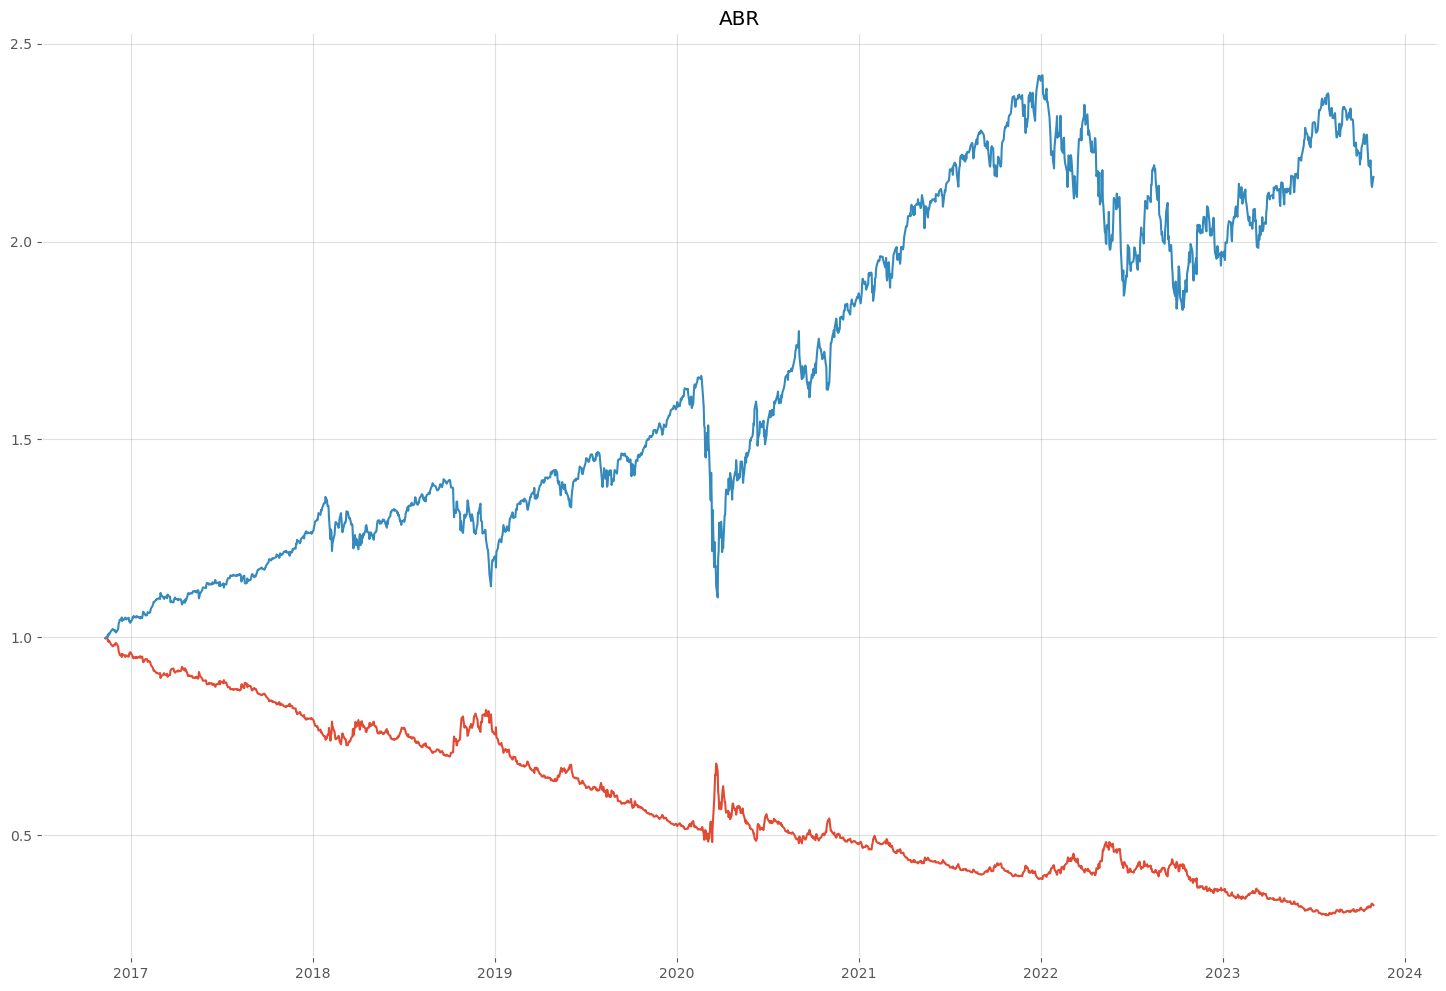

In [52]:
backtesting(models,1e5)

### Results

From the results above, we selected Random Forest model as one of our best strategy, with the following results:

RFR final capital: $373,659.60

RFR max drawdown: $3,882.60

RFR sharpe ratio: 1.089

RFR CAGR : 20.81%

> Why is it outstanding?

Multiple decision trees and random feature selection:
- Makes Random Forest less prone to overfitting training data, enhancing its generalization ability in the performance of the test data. We observe that LASSO,EN and SVR produced performances that mimick the test set data perfectly.
    
- More robust against the sudden drop in the market, e.g 2008 financial crisis & 2020 Covid-19.

- Performs slightly better than the Extra Trees model which has more random features, most probably because SPY maintains an upward trend in the long run.

# <a id = "meanreversion"></a><font color = "orange">2. Mean-Reversion Strategy</font> [back to table of contents](#toc)

## <font color = "blue">Mean-Reversion</font>

### Strategy overview

The principle behind determining our entry and exit rules is based on a Mean-Reverse trading strategy using Bollinger Bands, which are a type of statistical chart characterizing the prices and volatility of a financial instrument over time.

In [38]:
fx = pdr.get_data_yahoo("SPY",
                        start=dt.datetime(2004, 11, 1),
                        end=dt.datetime(2023, 10, 31)).dropna()
fx = fx.rename(columns={"Adj Close": "Price"})[["Price"]]
fx["return"]= fx["Price"]/fx["Price"].shift(1)


[*********************100%%**********************]  1 of 1 completed


### Strategic Explanation

#### Returns 

Unlike the traditional approach, the team decided to use return as our means. The reason is that the graph below ,price of sp500, shows a clear upward trend over the past twenty years which violates the assumption of mean reversion strategy. In mean reversion, it assumes that the stock price will revert to their historical mean or average price over time.However it is not supported by SP500,which tends to be above the average line in most occasions due to its strong upward trend.Hence, instead of Price, our team use Normal Return of SP500,a more stationary data when modeling the mean reversion strategy.  

#### Distance

"Distance" refers to the difference between the daily return of the S&P 500 index and its Simple Moving Average (SMA). Essentially, it measures the deviation of the current return from the average return over a specified period. In formula, it is calculated as Distance=Return-SMA. The "distance" thus represents how far the current return deviates from its recent average, indicating whether the current performance is above or below the typical performance for the given period.

#### Bollinger Bands

Bollinger Bands is a technical analysis tool to generate oversold or overbought signals and was developed by John Bollinger.
Three lines compose Bollinger Bands: A simple moving average, or the middle band, and an upper and lower band.
BOLU=MA(TP,n)+p*σ[TP,n]
BOLD=MA(TP,n)-q*σ[TP,n]
Where:
BOLU=Upper Bollinger Band
BOLD=Lower Bollinger Band
MA=Moving average
TP(typical price)=(High+Low+Close)/3
n=Number of days in smoothing period (typically20)
p= Upper band multipliers
q= lower band multipliers
σ[TP,n]=Standard Deviation over last n periods of TP

#### Entry rule

Firstly, we should identify the dates,when the Simple Moving Average (SMA) is approaching the lower boundary of the Bollinger Bands.In another word,we are searching for occasions where the current day's distance remains above the lower Bollinger Band,yet it is expected to drop below the threshold on the following trading day . This signal indicates that the asset was potentially oversold, prompting us to adjust our position to 1 and initiate a buy order. .

#### Exit rule

Correspondingly, we will look for dates when the present value of distance was below the upper Bollinger Band, and it crosses over the upper Bollinger Band. It suggests the asset may have been overbought and we might see a downturn in the near future. Hence, in our strategy, we will adjust our position back to zero, indicating a sell or not hold signal if the both conditions are met.


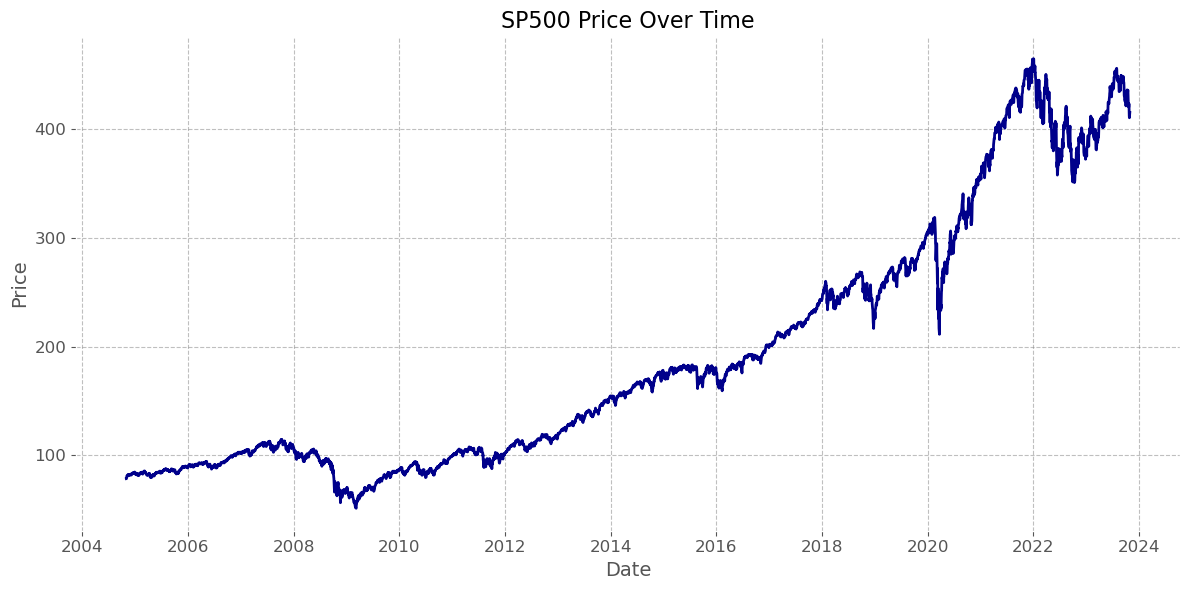

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(fx["Price"], color='darkblue', linewidth=2)
plt.title('SP500 Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

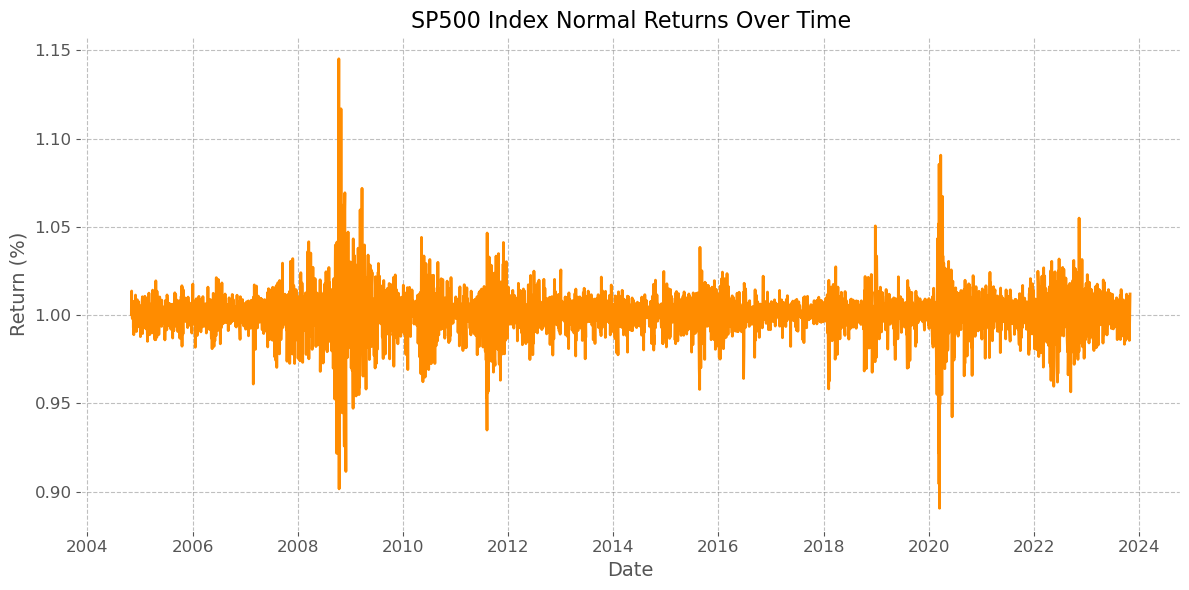

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(fx["return"], color='darkorange', linewidth=2)
plt.title('SP500 Index Normal Returns Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Return (%)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Parameter Selection Result analysis
In this approach, determining the order of the SMA, along with the upper and lower thresholds, serves as the primary focus in our search for the optimal strategy. Therefore, we use a for loop iterates over ranges of SMA periods and Bollinger Band multipliers. For each combination of parameters, it calculates the cumulative return and Sharpe Ratio.Finally we find the best set of parameters for the highest Sharpe Ratio and highest cumulative return.


In [41]:
def calculate_strategy(sma_period, upper_multiplier, lower_multiplier):
    sp500=fx.copy()
    sp500["SMA"] = sp500["return"].rolling(window=sma_period).mean()
    sp500["distance"] = sp500["return"] - sp500["SMA"]
    sp500["BB_upper"] = upper_multiplier * sp500["distance"].rolling(window=sma_period).std()
    sp500["BB_lower"] = -lower_multiplier * sp500["distance"].rolling(window=sma_period).std()
    sp500["position"] = np.where((sp500["distance"].shift(1) < sp500['BB_lower'].shift(1)) & 
                                 (sp500["distance"] >= sp500['BB_lower']), 1, np.nan)
    sp500["position"] = np.where((sp500["distance"].shift(1) > sp500['BB_upper'].shift(1)) & 
                                 (sp500["distance"] <= sp500['BB_upper']), 0, sp500["position"])
    sp500["position"].ffill(inplace=True)
    sp500["position"].fillna(0, inplace=True)
    sp500['trading_signal'] = sp500['position'].diff()
    sp500["log_return"]=np.log(sp500["return"])

    sp500['strategy_returns'] = (sp500['log_return'] * sp500['position'].shift(1)).apply(np.exp)
    sp500.dropna(inplace=True)

    # Initialize cumulative capital
    sp500['cumulative_capital'] = 100000
    for i in range(1, len(sp500)):  
        sp500['cumulative_capital'].iloc[i] = sp500['cumulative_capital'].iloc[i-1] * sp500['strategy_returns'].iloc[i]
    
    sp500['cumulative_return'] = (sp500['cumulative_capital'] - 100000) / 100000
    
    sharpe_ratio = (np.sqrt(253)*(sp500['cumulative_capital'] / sp500['cumulative_capital'].shift(1)-1).mean())/((sp500['cumulative_capital'] / sp500['cumulative_capital'].shift(1)-1).std())

    return sp500['cumulative_return'].iloc[-1],sharpe_ratio
    

sma_range = range(5,252) 
upper_multiplier_range = range(1,4) 
lower_multiplier_range = range(1,4)  

results = {}


for sma_period in sma_range:
    for upper_multiplier in upper_multiplier_range:
        for lower_multiplier in lower_multiplier_range:
            cum_return, sharpe_ratio = calculate_strategy(sma_period, upper_multiplier, lower_multiplier)
            results[(sma_period, upper_multiplier, lower_multiplier)] = (cum_return, sharpe_ratio)

best_params = max(results, key=lambda x: results[x][1])  # Compare based on cumulative return
best_cumulative_return, best_sharpe_ratio = results[best_params]

print("Best Parameters (SMA, Upper Multiplier, Lower Multiplier):", best_params)
print("Cumulative Return with best Sharpe Ratio:", best_cumulative_return)
print("Best Sharpe Ratio:", best_sharpe_ratio)

Best Parameters (SMA, Upper Multiplier, Lower Multiplier): (7, 3, 3)
Cumulative Return with best Sharpe Ratio: 4.448329390197969
Best Sharpe Ratio: 0.6739511115285461


In [42]:
# Convert dictionary into a list of tuples (key, value) and sort by value in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

# Print the sorted results
for params, cum_return in sorted_results:
    print(f"Parameters: {params}, Cumulative Return: {cum_return}")

Parameters: (20, 3, 2), Cumulative Return: (4.6900307510909425, 0.6070745323192057)
Parameters: (21, 3, 2), Cumulative Return: (4.654640130908894, 0.6054080342616691)
Parameters: (22, 3, 2), Cumulative Return: (4.619087292804358, 0.603484998619011)
Parameters: (5, 2, 1), Cumulative Return: (4.4855542573879035, 0.5724852143728606)
Parameters: (7, 3, 3), Cumulative Return: (4.448329390197969, 0.6739511115285461)
Parameters: (19, 3, 2), Cumulative Return: (4.384621533826392, 0.5908343474443979)
Parameters: (18, 3, 2), Cumulative Return: (4.384621533826392, 0.5907096977845153)
Parameters: (17, 3, 2), Cumulative Return: (4.384621533826392, 0.5905851269842525)
Parameters: (16, 3, 2), Cumulative Return: (4.384621533826392, 0.5904606349604874)
Parameters: (30, 3, 1), Cumulative Return: (4.265365870280423, 0.5595140115283956)
Parameters: (29, 3, 1), Cumulative Return: (4.265365870280423, 0.5593954367862047)
Parameters: (27, 3, 2), Cumulative Return: (4.236882053844324, 0.5855078779796826)
Param

#### Parameter set with highest sharpe ratio: SMA_days=7,Upper Multiplier=3,Lower Multiplier=3
The first choice of the parameter  set  is determined  based on the sharpe ratio generated by the strategy. Here, we get the cumulative return is 4.448328 and the Sharpe Ratio is 0.673951.However, as observed in the graph above, our strategy did not execute trades from 2004 to 2008. Although it reduced the volatility of returns, potentially resulting in a higher Sharpe ratio, it is not ideal since it missed numerous opportunities for profit-making during this period.


In [43]:
sp500=fx.copy()
sp500["SMA"] = sp500["return"].rolling(window=7).mean()
sp500["distance"] = sp500["return"] - sp500["SMA"]
sp500["BB_upper"] = 3 * sp500["distance"].rolling(window=7).std()
sp500["BB_lower"] = -3 * sp500["distance"].rolling(window=7).std() 
sp500["position"] = np.where((sp500["distance"].shift(1) < sp500['BB_lower'].shift(1)) & (sp500["distance"] >= sp500['BB_lower']), 1, np.nan)
sp500["position"] = np.where((sp500["distance"].shift(1) > sp500['BB_upper'].shift(1)) & (sp500["distance"] <= sp500['BB_upper']), 0, sp500["position"])

sp500["position"].ffill(inplace=True)
sp500["position"].fillna(0, inplace=True)
sp500['trading_signal'] = sp500['position'].diff()  
sp500["log_return"]=np.log(sp500["return"])
sp500['strategy_returns'] = (sp500['log_return'] * sp500['position'].shift(1)).apply(np.exp)
sp500.dropna(inplace=True)

    # Initialize cumulative capital
sp500['cumulative_capital'] = 100000
for i in range(1, len(sp500)):  
    sp500['cumulative_capital'].iloc[i] = sp500['cumulative_capital'].iloc[i-1] * sp500['strategy_returns'].iloc[i]
sp500['cash'] = 100000  
for i in range(1, len(sp500)):  
    sp500['cash'].iloc[i] =sp500['cash'].iloc[i]/sp500["Price"].iloc[1]*sp500["Price"].iloc[i]
sp500['cumulative_return'] = (sp500['cumulative_capital'] - 100000) / 100000
    
sharpe_ratio = np.sqrt(253)*(sp500['cumulative_capital'] / sp500['cumulative_capital'].shift(1)-1).mean()/(sp500['cumulative_capital'] / sp500['cumulative_capital'].shift(1)-1).std()



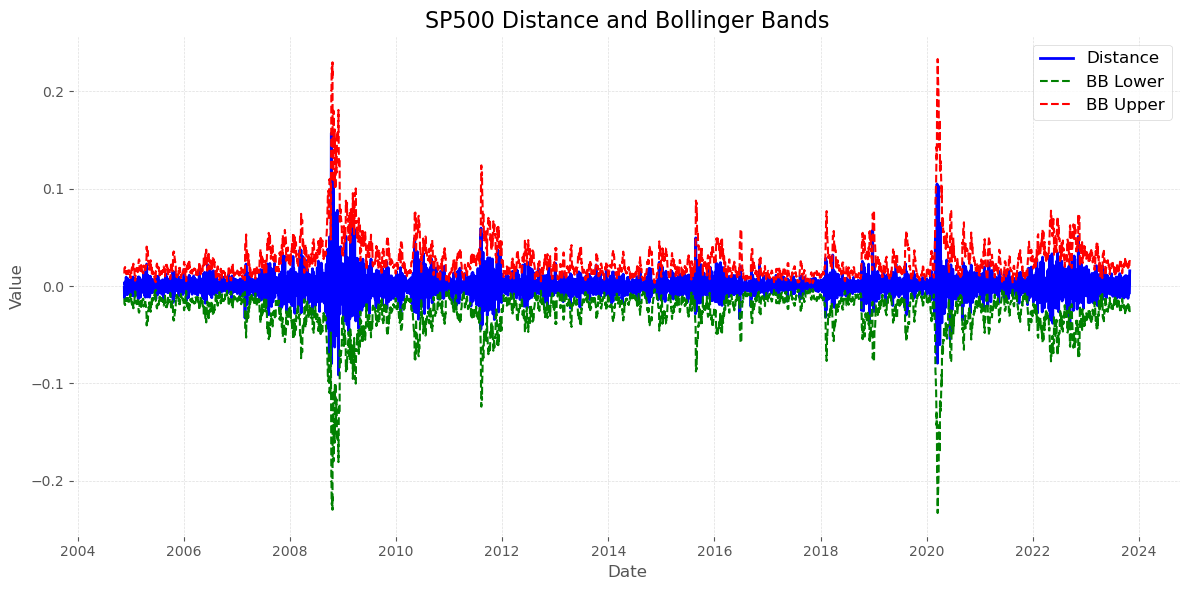

In [44]:
plt.figure(figsize=(12, 6))  
plt.plot(sp500["distance"], label='Distance', color='blue', linewidth=2) 
plt.plot(sp500["BB_lower"], label='BB Lower', color='green', linestyle='--')
plt.plot(sp500["BB_upper"], label='BB Upper', color='red', linestyle='--') 
plt.title('SP500 Distance and Bollinger Bands', fontsize=16) 
plt.xlabel('Date', fontsize=12)  
plt.ylabel('Value', fontsize=12) 
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.show()


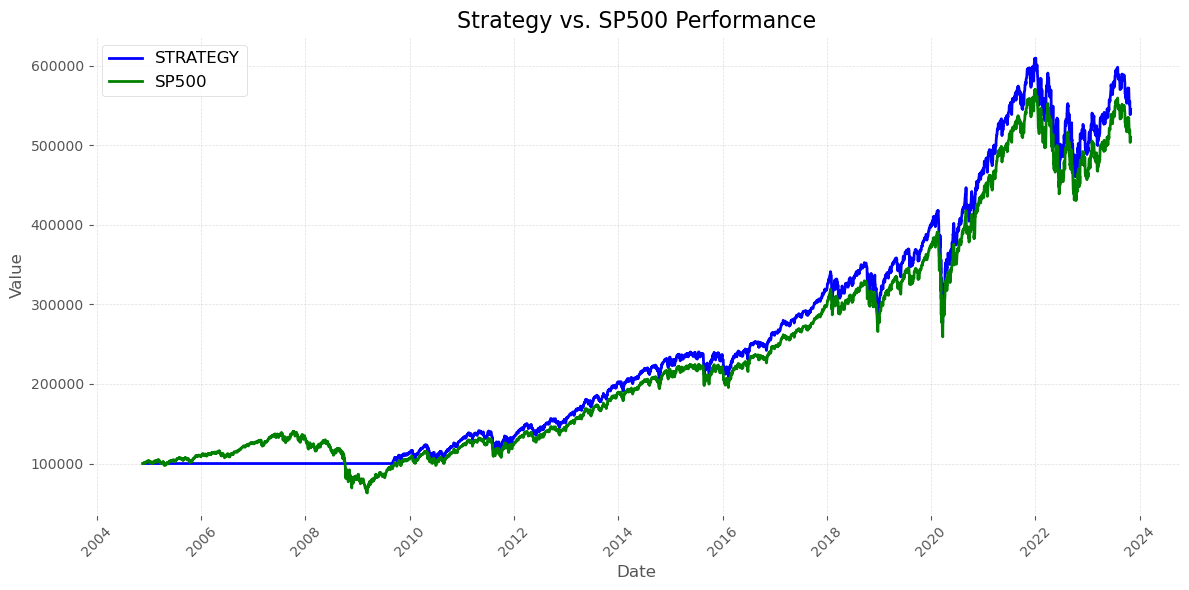

In [45]:
plt.figure(figsize=(12, 6))  # Set the size of the plot
plt.plot(sp500["cumulative_capital"], label='STRATEGY', color='blue', linewidth=2)  # Strategy line
plt.plot(sp500["cash"], label='SP500', color='green', linewidth=2)  # SP500 line

plt.title('Strategy vs. SP500 Performance', fontsize=16)  # Chart title
plt.xlabel('Date', fontsize=12)  # X-axis label
plt.ylabel('Value', fontsize=12)  # Y-axis label


plt.xticks(fontsize=10, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)


plt.legend(fontsize=12)


plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()  
plt.show()

#### Parameter set with highest Cumulative Return:SMA_days=20,Upper Multiplier=3,Lower Multiplier=2
Another choice of the parameter  set  is determined  based on the cumulative return produced by the strategy. In this case, the cumulative return is 4.69003 with a Sharpe Ratio of 0.607075. Even though this strategy involves a higher volatility in returns, it captures more profit opportunities and ultimately yields a higher return. Therefore, the team will use the result produced by this parameter set for analyzing results.


In [46]:
sp500=fx.copy()
sp500["SMA"] = sp500["return"].rolling(window=20).mean()
sp500["distance"] = sp500["return"] - sp500["SMA"]
sp500["BB_upper"] = 3 * sp500["distance"].rolling(window=20).std()
sp500["BB_lower"] = -2 * sp500["distance"].rolling(window=20).std() 
sp500["position"] = np.where((sp500["distance"].shift(1) < sp500['BB_lower'].shift(1)) & (sp500["distance"] >= sp500['BB_lower']), 1, np.nan)
sp500["position"] = np.where((sp500["distance"].shift(1) > sp500['BB_upper'].shift(1)) & (sp500["distance"] <= sp500['BB_upper']), 0, sp500["position"])

sp500["position"].ffill(inplace=True)
sp500["position"].fillna(0, inplace=True)
sp500['trading_signal'] = sp500['position'].diff()  
sp500["log_return"]=np.log(sp500["return"])
sp500['strategy_returns'] = (sp500['log_return'] * sp500['position'].shift(1)).apply(np.exp)
sp500.dropna(inplace=True)

    # Initialize cumulative capital
sp500['cumulative_capital'] = 100000
for i in range(1, len(sp500)):  
    sp500['cumulative_capital'].iloc[i] = sp500['cumulative_capital'].iloc[i-1] * sp500['strategy_returns'].iloc[i]
sp500['cash'] = 100000  
for i in range(1, len(sp500)):  
    sp500['cash'].iloc[i] =sp500['cash'].iloc[i]/sp500["Price"].iloc[1]*sp500["Price"].iloc[i]
sp500['cumulative_return'] = (sp500['cumulative_capital'] - 100000) / 100000
    
sharpe_ratio = np.sqrt(253)*(sp500['cumulative_capital'] / sp500['cumulative_capital'].shift(1)-1).mean()/(sp500['cumulative_capital'] / sp500['cumulative_capital'].shift(1)-1).std()


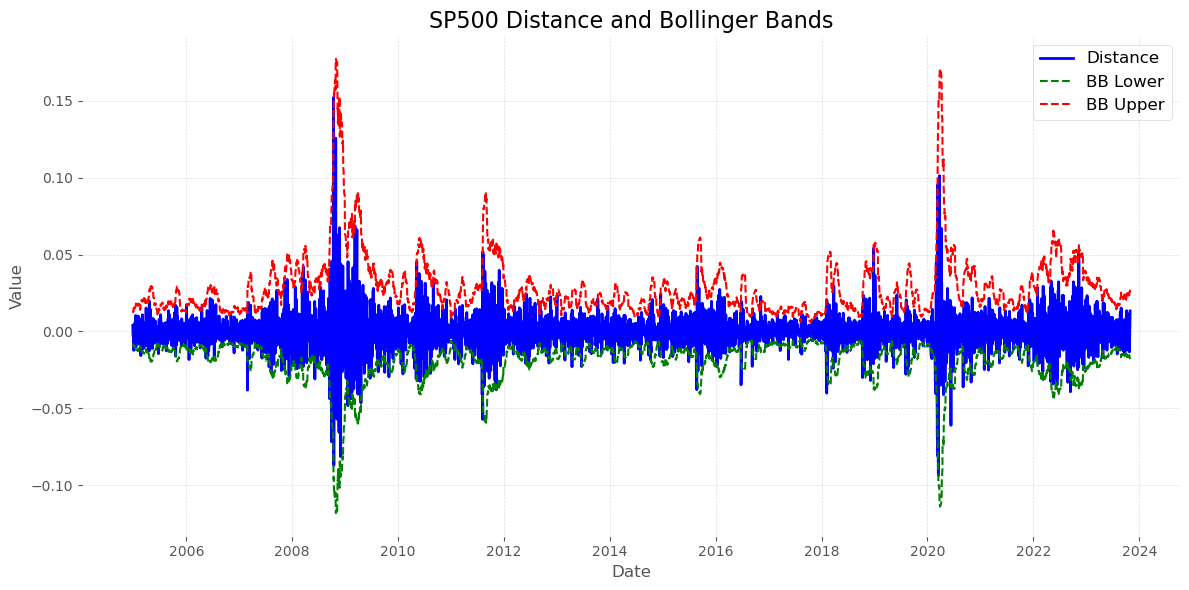

In [47]:
plt.figure(figsize=(12, 6))  
plt.plot(sp500["distance"], label='Distance', color='blue', linewidth=2) 
plt.plot(sp500["BB_lower"], label='BB Lower', color='green', linestyle='--')
plt.plot(sp500["BB_upper"], label='BB Upper', color='red', linestyle='--') 
plt.title('SP500 Distance and Bollinger Bands', fontsize=16) 
plt.xlabel('Date', fontsize=12)  
plt.ylabel('Value', fontsize=12) 
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.show()

### Result Analysis
As observed from the graph, our strategies perform reasonably well.During the past 20 years, its return managed to outperform the sp500 index. A more comprehensive detailed analysis will be conducted in the subsequent code segment


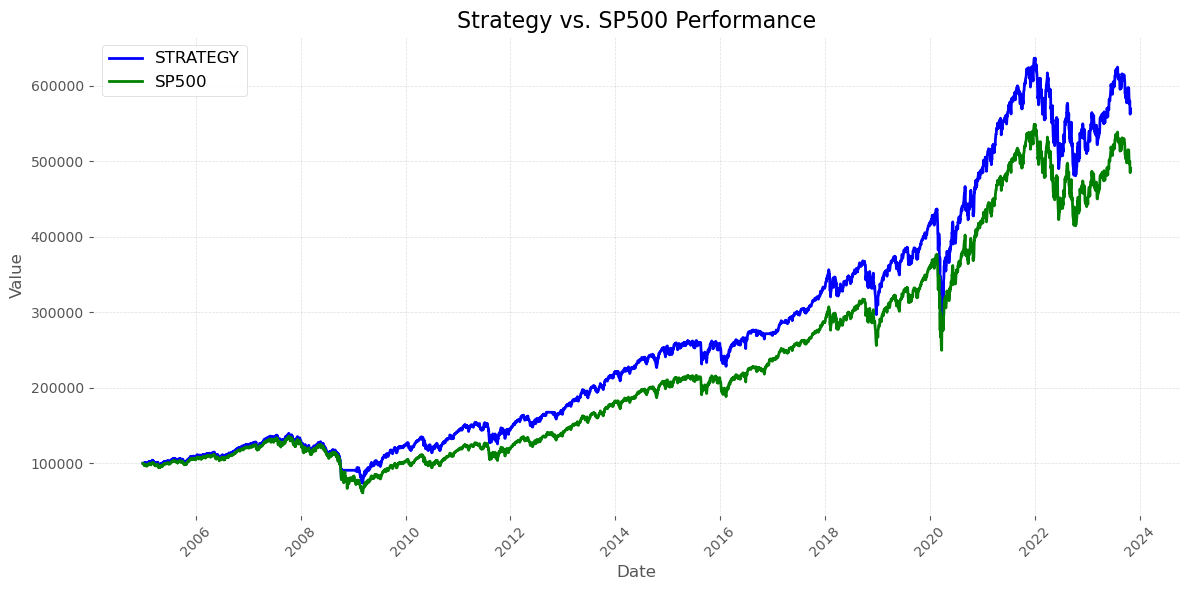

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(sp500["cumulative_capital"], label='STRATEGY', color='blue', linewidth=2) 
plt.plot(sp500["cash"], label='SP500', color='green', linewidth=2) 
plt.title('Strategy vs. SP500 Performance', fontsize=16)  
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Value', fontsize=12)
plt.xticks(fontsize=10, rotation=45)  
plt.yticks(fontsize=10)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  
plt.show()

#### Drawdown
The drawdown grpah shows varied performance across years, with some years yielding high positive returns (e.g., 2019, 2021) and others experiencing significant losses (e.g., 2008, 2022)

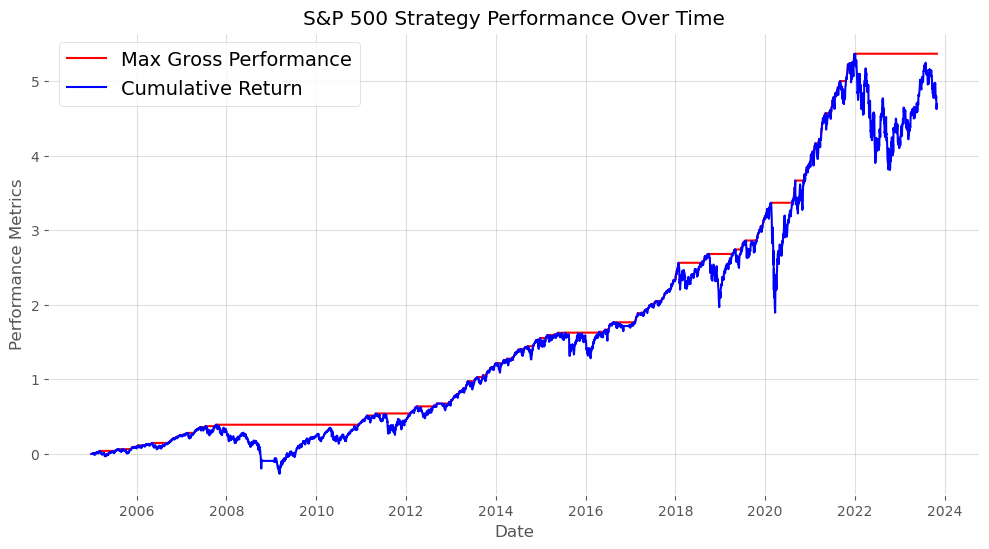

In [50]:
sp500["max_gross_performance"] =sp500["cumulative_return"].cummax()
plt.figure(figsize=(12, 6))
plt.plot(sp500["max_gross_performance"], label='Max Gross Performance', color='r')
plt.plot(sp500["cumulative_return"], label='Cumulative Return', color='b')
plt.title('S&P 500 Strategy Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
  
sp500['drawdown'] =\
    (sp500["max_gross_performance"]-sp500["cumulative_return"])

Drawdown = pd.DataFrame(columns = ['start','end','max','duration'],
                        index = range(len(sp500[sp500['drawdown']==0])-1))
row=0
for i in range(len(sp500)) :
        for j in range(i+1,len(sp500)) :
            max_array = np.array([])
            if sp500['drawdown'][i] == 0 and sp500['drawdown'][j] == 0 :
                Drawdown['start'][row] = sp500.index[i]
                Drawdown['end'][row] = sp500.index[j]
                Drawdown['duration'][row] = (Drawdown['end'][row] - Drawdown['start'][row]).days
                for k in sp500['drawdown'].iloc[i:j+1] :
                    max_array = np.append(max_array , k)
                    Drawdown['max'][row] = max_array.max()
                row += 1
                break
for i in Drawdown['max'].astype('float64').nlargest(5).index :
    print(f"net drawdown = {Drawdown['max'][i]} , duration ={Drawdown['duration'][i]}days")

net drawdown = 1.4726035171405343 , duration =173days
net drawdown = 0.7122398703997495 , duration =204days
net drawdown = 0.6570889639838827 , duration =1158days
net drawdown = 0.4403969724568788 , duration =70days
net drawdown = 0.3599235459241741 , duration =192days


#### Annual Return
We first compute the difference in cumulative capital at the beginning and end of each year, then calculate the percentage return for each year based on this difference. We calculate the mean of these annual percentage returns, providing an average yearly performance metric for the investment strategy.
In general, the strategy managed to outperform the S&P 500 in most ocassions.However, it appears to exhibit higher volatility compared to the S&P 500, as indicated by larger swings in annual returns, which suggests a higher risk profile.

In [52]:
def get_annual_returns(stock):
    stock_first = stock.groupby(stock.index.year).first()
    stock_last = stock.groupby(stock.index.year).last()

    returns = pd.DataFrame()
    returns['Strategy Annual Returns ($)'] = stock_last['cumulative_capital'] - stock_first['cumulative_capital']
    returns['Strategy Cumulative Capital ($)'] = stock_first['cumulative_capital']
    returns['S&P 500 Annual Returns ($)'] = stock_last['cash'] - stock_first['cash']
    returns['S&P 500 Cumulative Capital ($)'] = stock_first['cash']
    returns.iloc[0, 1] = 100000
    returns['Strategy Returns (%)'] = (returns['Strategy Annual Returns ($)'] / returns['Strategy Cumulative Capital ($)']) * 100
    returns['S&P 500 Returns (%)'] = (returns['S&P 500 Annual Returns ($)'] / returns['S&P 500 Cumulative Capital ($)']) * 100
    print('Strategy Mean Annual Returns: ' + str(returns['Strategy Returns (%)'].mean()))
    print('S&P 500 Mean Annual Returns: ' + str(returns["S&P 500 Returns (%)"].mean()))
    columns_order = ['Strategy Annual Returns ($)', 'S&P 500 Annual Returns ($)', 'Strategy Returns (%)', 'S&P 500 Returns (%)','Strategy Cumulative Capital ($)', 'S&P 500 Cumulative Capital ($)' ]
    returns = returns[columns_order]
    returns_styled = returns.style.format({
        'Strategy Annual Returns ($)': '${:,.2f}',
        'Strategy Returns (%)': '{:.2f}%',
        'Strategy Cumulative Capital ($)': '${:,.2f}',
        'S&P 500 Annual Returns ($)': '${:,.2f}',
        'S&P 500 Cumulative Capital ($)': '${:,.2f}',
        'S&P 500 Returns (%)': '{:.2f}%'
    }).set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#f4f4f4'), ('color', 'black')]
    }])

    return returns_styled

get_annual_returns(sp500)

Strategy Mean Annual Returns: 10.006459091093445
S&P 500 Mean Annual Returns: 9.15849009896135


# <a id = "momentum"></a><font color = "orange">3. Momentum Strategy</font> [back to table of contents](#toc)

## <font color = "blue">Moving Average</font>

We used the simple moving average strategy with short term moving average of 10 days and long term moving average of 77 days to obtain the following results. We have defined a function to get the best short term and long term moving averages to be applied in the stratergy to beat the market and the results show that the Short Period = 10 and Long Period = 77 gives us the best results.

### Set Up

In [4]:
SP500 =\
(
    pdr
    .get_data_yahoo("SPY",
                    start = dt.datetime(2004, 11, 1),
                    end = dt.datetime(2023, 10, 31)
                   )
)
def calculate_sma_strategy(SP500, short_window, long_window):
    data=SP500.copy()
    data['SMA_short'] = data['Adj Close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['Adj Close'].rolling(window=long_window).mean()
    data['positions'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    data['log_returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

    data['strategy_returns'] = data['positions'].shift(1) * data['log_returns']
    data['cumulative_returns'] = data['strategy_returns'].cumsum().apply(np.exp)
    return data['cumulative_returns'].iloc[-1]

short_sma_range = range(5,100)  
long_sma_range = range(5, 252)  
results = {}
for short_sma in short_sma_range:
    for long_sma in long_sma_range:
        if long_sma > short_sma:  
            cumulative_return = calculate_sma_strategy(SP500, short_sma, long_sma)
            results[(short_sma, long_sma)] = cumulative_return
best_params = max(results, key=results.get)
best_cumulative_return = results[best_params]
print("Best Parameters (Short SMA, Long SMA):", best_params)
print("Best Cumulative Return:", best_cumulative_return)

[*********************100%%**********************]  1 of 1 completed
Best Parameters (Short SMA, Long SMA): (10, 77)
Best Cumulative Return: 4.95902115561476


In [8]:
# short-term simple moving averages = 10 days
# long-term simple moving averages = 77 days

# SSMA

SP500["SMA_10"] =\
(
    SP500
    ["Adj Close"]
    .rolling(window = 10)
    .mean()
)

# LSMA

SP500["SMA_77"] =\
(
    SP500
    ["Adj Close"]
    .rolling(window = 77)
    .mean()
)

In [9]:
SP500 =\
(
    SP500
    .dropna()
)

SP500

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-02-18  120.239998  120.480003  119.900002  120.389999   84.025230   
2005-02-22  119.900002  120.470001  118.580002  118.599998   82.775894   
2005-02-23  118.930000  119.570000  118.620003  119.449997   83.369156   
2005-02-24  119.239998  120.320000  118.980003  120.239998   83.920570   
2005-02-25  120.269997  121.669998  120.180000  121.430000   84.751106   
...                ...         ...         ...         ...         ...   
2023-10-24  422.649994  424.820007  420.739990  423.630005  423.630005   
2023-10-25  421.890015  421.920013  417.019989  417.549988  417.549988   
2023-10-26  416.450012  417.329987  411.600006  412.549988  412.549988   
2023-10-27  414.190002  414.600006  409.209991  410.679993  410.679993   
2023-10-30  413.559998  416.679993  412.220001  415.589996  415.589996   

               Volume      SMA_10      SMA_77  
Date                                           
2005-02-18   47723300   84.014071   82.714085  
2005-02-22   80697600   83.911472   82.768085  
2005-02-23   68292600   83.858427   82.829429  
2005-02-24   68563600   83.923338   82.885072  
2005-02-25   60899900   84.041293   82.937379  
...               ...         ...         ...  
2023-10-24   78564200  429.545999  440.351542  
2023-10-25   94223200  427.668997  440.098834  
2023-10-26  115156800  425.557996  439.766825  
2023-10-27  107367700  423.475995  439.374296  
2023-10-30   86562700  421.430994  438.999462  

[4706 rows x 8 columns]

In [10]:
SP500["positions"] =\
(
    np
    .where(SP500["SMA_10"] > SP500["SMA_77"],
           1, 0)
)

SP500

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-02-18  120.239998  120.480003  119.900002  120.389999   84.025230   
2005-02-22  119.900002  120.470001  118.580002  118.599998   82.775894   
2005-02-23  118.930000  119.570000  118.620003  119.449997   83.369156   
2005-02-24  119.239998  120.320000  118.980003  120.239998   83.920570   
2005-02-25  120.269997  121.669998  120.180000  121.430000   84.751106   
...                ...         ...         ...         ...         ...   
2023-10-24  422.649994  424.820007  420.739990  423.630005  423.630005   
2023-10-25  421.890015  421.920013  417.019989  417.549988  417.549988   
2023-10-26  416.450012  417.329987  411.600006  412.549988  412.549988   
2023-10-27  414.190002  414.600006  409.209991  410.679993  410.679993   
2023-10-30  413.559998  416.679993  412.220001  415.589996  415.589996   

               Volume      SMA_10      SMA_77  positions  
Date                                                      
2005-02-18   47723300   84.014071   82.714085          1  
2005-02-22   80697600   83.911472   82.768085          1  
2005-02-23   68292600   83.858427   82.829429          1  
2005-02-24   68563600   83.923338   82.885072          1  
2005-02-25   60899900   84.041293   82.937379          1  
...               ...         ...         ...        ...  
2023-10-24   78564200  429.545999  440.351542          0  
2023-10-25   94223200  427.668997  440.098834          0  
2023-10-26  115156800  425.557996  439.766825          0  
2023-10-27  107367700  423.475995  439.374296          0  
2023-10-30   86562700  421.430994  438.999462          0  

[4706 rows x 9 columns]

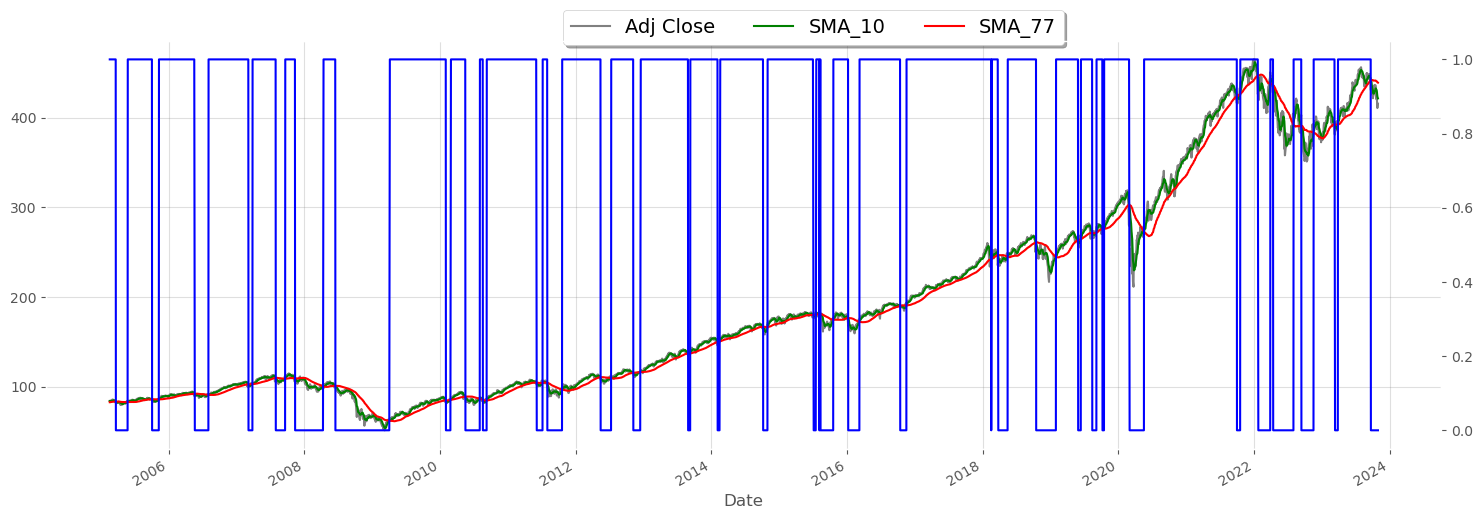

In [12]:
ax =\
(
    SP500
    [["Adj Close", 
      "SMA_10", 
      "SMA_77", 
      "positions"]]
    .plot(secondary_y = "positions",
          style = ["grey", 
                   "green",
                   "red",
                   "blue"],
          figsize = [18, 6]
         )
)

(
    ax
    .legend(loc = "upper center",
            shadow = True,
            ncol = 4,
            bbox_to_anchor = (0.55, 1.10),
            fancybox = True)
)

In [13]:
SP500["log_returns"] =\
(
    np
    .log(SP500["Adj Close"] / SP500["Adj Close"].shift(1)
        )
)

SP500

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-02-18  120.239998  120.480003  119.900002  120.389999   84.025230   
2005-02-22  119.900002  120.470001  118.580002  118.599998   82.775894   
2005-02-23  118.930000  119.570000  118.620003  119.449997   83.369156   
2005-02-24  119.239998  120.320000  118.980003  120.239998   83.920570   
2005-02-25  120.269997  121.669998  120.180000  121.430000   84.751106   
...                ...         ...         ...         ...         ...   
2023-10-24  422.649994  424.820007  420.739990  423.630005  423.630005   
2023-10-25  421.890015  421.920013  417.019989  417.549988  417.549988   
2023-10-26  416.450012  417.329987  411.600006  412.549988  412.549988   
2023-10-27  414.190002  414.600006  409.209991  410.679993  410.679993   
2023-10-30  413.559998  416.679993  412.220001  415.589996  415.589996   

               Volume      SMA_10      SMA_77  positions  log_returns  
Date                                                                   
2005-02-18   47723300   84.014071   82.714085          1          NaN  
2005-02-22   80697600   83.911472   82.768085          1    -0.014980  
2005-02-23   68292600   83.858427   82.829429          1     0.007142  
2005-02-24   68563600   83.923338   82.885072          1     0.006592  
2005-02-25   60899900   84.041293   82.937379          1     0.009848  
...               ...         ...         ...        ...          ...  
2023-10-24   78564200  429.545999  440.351542          0     0.007511  
2023-10-25   94223200  427.668997  440.098834          0    -0.014456  
2023-10-26  115156800  425.557996  439.766825          0    -0.012047  
2023-10-27  107367700  423.475995  439.374296          0    -0.004543  
2023-10-30   86562700  421.430994  438.999462          0     0.011885  

[4706 rows x 10 columns]

In [14]:
SP500["strategy_returns"] =\
(
    SP500["positions"]
    .shift(1) 
    * 
    SP500["log_returns"]
)

SP500["strategy_returns"]

Date
2005-02-18         NaN
2005-02-22   -0.014980
2005-02-23    0.007142
2005-02-24    0.006592
2005-02-25    0.009848
                ...   
2023-10-24    0.000000
2023-10-25   -0.000000
2023-10-26   -0.000000
2023-10-27   -0.000000
2023-10-30    0.000000
Name: strategy_returns, Length: 4706, dtype: float64

In [15]:
SP500[["log_returns", "strategy_returns"]]

log_returns  strategy_returns
Date                                     
2005-02-18          NaN               NaN
2005-02-22    -0.014980         -0.014980
2005-02-23     0.007142          0.007142
2005-02-24     0.006592          0.006592
2005-02-25     0.009848          0.009848
...                 ...               ...
2023-10-24     0.007511          0.000000
2023-10-25    -0.014456         -0.000000
2023-10-26    -0.012047         -0.000000
2023-10-27    -0.004543         -0.000000
2023-10-30     0.011885          0.000000

[4706 rows x 2 columns]

In [17]:
(
    SP500
    [["log_returns", "strategy_returns"]]
    .sum()
).apply(np.exp)

log_returns         4.946014
strategy_returns    4.959021
dtype: float64

<Axes: xlabel='Date'>

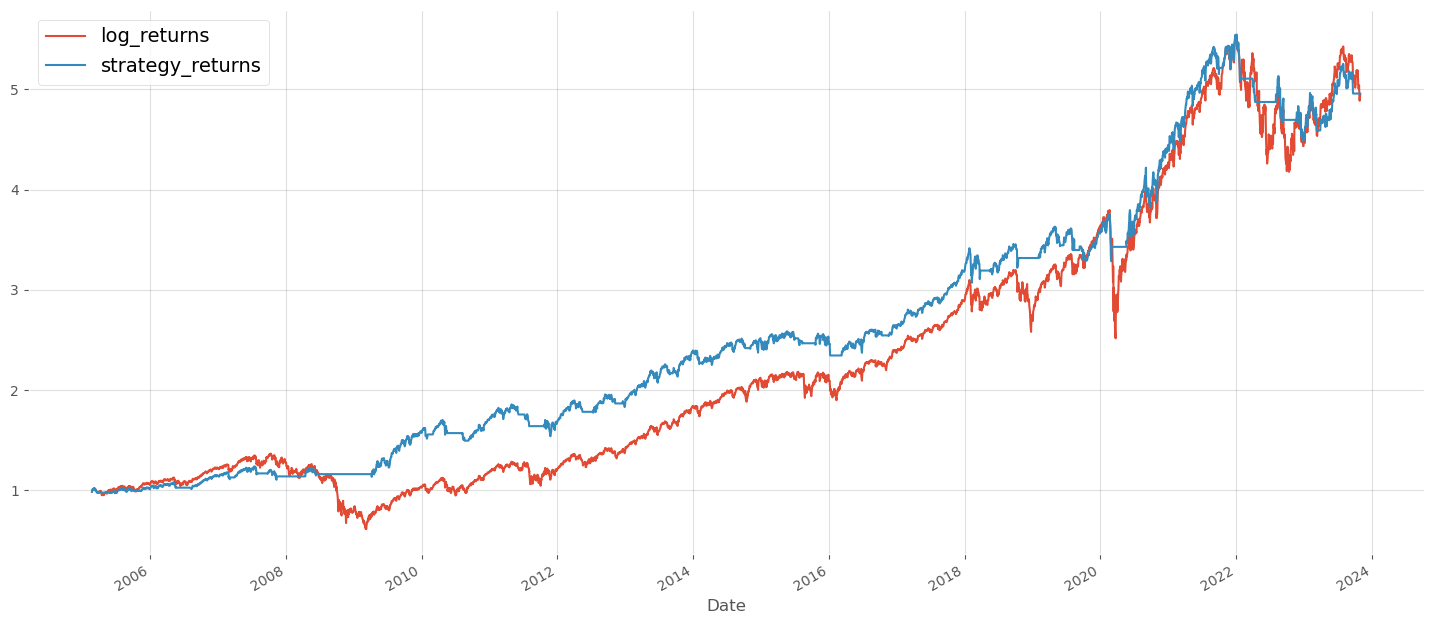

In [16]:
(
    SP500
    [["log_returns", "strategy_returns"]]
    .cumsum()
    .apply(np.exp)
).plot(figsize = [18, 8]
      )

In [18]:
SP500["cumulative_returns"] =\
(
    SP500["strategy_returns"]
    .cumsum()
    .apply(np.exp)
)

SP500

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-02-18  120.239998  120.480003  119.900002  120.389999   84.025230   
2005-02-22  119.900002  120.470001  118.580002  118.599998   82.775894   
2005-02-23  118.930000  119.570000  118.620003  119.449997   83.369156   
2005-02-24  119.239998  120.320000  118.980003  120.239998   83.920570   
2005-02-25  120.269997  121.669998  120.180000  121.430000   84.751106   
...                ...         ...         ...         ...         ...   
2023-10-24  422.649994  424.820007  420.739990  423.630005  423.630005   
2023-10-25  421.890015  421.920013  417.019989  417.549988  417.549988   
2023-10-26  416.450012  417.329987  411.600006  412.549988  412.549988   
2023-10-27  414.190002  414.600006  409.209991  410.679993  410.679993   
2023-10-30  413.559998  416.679993  412.220001  415.589996  415.589996   

               Volume      SMA_10      SMA_77  positions  log_returns  \
Date                                                                    
2005-02-18   47723300   84.014071   82.714085          1          NaN   
2005-02-22   80697600   83.911472   82.768085          1    -0.014980   
2005-02-23   68292600   83.858427   82.829429          1     0.007142   
2005-02-24   68563600   83.923338   82.885072          1     0.006592   
2005-02-25   60899900   84.041293   82.937379          1     0.009848   
...               ...         ...         ...        ...          ...   
2023-10-24   78564200  429.545999  440.351542          0     0.007511   
2023-10-25   94223200  427.668997  440.098834          0    -0.014456   
2023-10-26  115156800  425.557996  439.766825          0    -0.012047   
2023-10-27  107367700  423.475995  439.374296          0    -0.004543   
2023-10-30   86562700  421.430994  438.999462          0     0.011885   

            strategy_returns  cumulative_returns  
Date                                              
2005-02-18               NaN                 NaN  
2005-02-22         -0.014980            0.985131  
2005-02-23          0.007142            0.992192  
2005-02-24          0.006592            0.998754  
2005-02-25          0.009848            1.008639  
...                      ...                 ...  
2023-10-24          0.000000            4.959021  
2023-10-25         -0.000000            4.959021  
2023-10-26         -0.000000            4.959021  
2023-10-27         -0.000000            4.959021  
2023-10-30          0.000000            4.959021  

[4706 rows x 12 columns]

### Backtesting

In [24]:
Capital = 1e5

In [25]:
SP500['Cumulative_Value'] = Capital * SP500['cumulative_returns']

In [26]:
SP500

Open        High         Low       Close   Adj Close  \
Date                                                                     
2005-02-18  120.239998  120.480003  119.900002  120.389999   84.025230   
2005-02-22  119.900002  120.470001  118.580002  118.599998   82.775894   
2005-02-23  118.930000  119.570000  118.620003  119.449997   83.369156   
2005-02-24  119.239998  120.320000  118.980003  120.239998   83.920570   
2005-02-25  120.269997  121.669998  120.180000  121.430000   84.751106   
...                ...         ...         ...         ...         ...   
2023-10-24  422.649994  424.820007  420.739990  423.630005  423.630005   
2023-10-25  421.890015  421.920013  417.019989  417.549988  417.549988   
2023-10-26  416.450012  417.329987  411.600006  412.549988  412.549988   
2023-10-27  414.190002  414.600006  409.209991  410.679993  410.679993   
2023-10-30  413.559998  416.679993  412.220001  415.589996  415.589996   

               Volume      SMA_10      SMA_77  positions  log_returns  \
Date                                                                    
2005-02-18   47723300   84.014071   82.714085          1          NaN   
2005-02-22   80697600   83.911472   82.768085          1    -0.014980   
2005-02-23   68292600   83.858427   82.829429          1     0.007142   
2005-02-24   68563600   83.923338   82.885072          1     0.006592   
2005-02-25   60899900   84.041293   82.937379          1     0.009848   
...               ...         ...         ...        ...          ...   
2023-10-24   78564200  429.545999  440.351542          0     0.007511   
2023-10-25   94223200  427.668997  440.098834          0    -0.014456   
2023-10-26  115156800  425.557996  439.766825          0    -0.012047   
2023-10-27  107367700  423.475995  439.374296          0    -0.004543   
2023-10-30   86562700  421.430994  438.999462          0     0.011885   

            strategy_returns  cumulative_returns          Value  \
Date                                                              
2005-02-18               NaN                 NaN            NaN   
2005-02-22         -0.014980            0.985131   98513.141545   
2005-02-23          0.007142            0.992192   99219.193425   
2005-02-24          0.006592            0.998754   99875.442134   
2005-02-25          0.009848            1.008639  100863.878446   
...                      ...                 ...            ...   
2023-10-24          0.000000            4.959021  495902.115561   
2023-10-25         -0.000000            4.959021  495902.115561   
2023-10-26         -0.000000            4.959021  495902.115561   
2023-10-27         -0.000000            4.959021  495902.115561   
2023-10-30          0.000000            4.959021  495902.115561   

            Cumulative_Value  
Date                          
2005-02-18               NaN  
2005-02-22      98513.141545  
2005-02-23      99219.193425  
2005-02-24      99875.442134  
2005-02-25     100863.878446  
...                      ...  
2023-10-24     495902.115561  
2023-10-25     495902.115561  
2023-10-26     495902.115561  
2023-10-27     495902.115561  
2023-10-30     495902.115561  

[4706 rows x 14 columns]

### Performance Metrics

#### Sharpe Ratio

In [27]:
# CALCULATE THE SHARPE RATIO OF THE STRATEGY
Sharpe =\
(
    np.sqrt(253) * (SP500["strategy_returns"].mean() / SP500["strategy_returns"].std()
                    )
)

Sharpe

0.7472561414762637

The Sharpe Ratio of this particular strategy is 0.747, higher than the market sharpe ratio of 0.608. Therefore we can conclude that our strategy has better risk adjusted performance. (The Sharpe Ratio provides a measure of how well an investment has performed relative to the level of risk it has taken. Higher Sharpe Ratios generally indicate better risk-adjusted performance.)

#### CAGR

In [28]:
# CALCULATE THE CAGR(COMPOUNED ANNUAL GROWTH RATE)
days =\
(    (SP500.index[-1] - SP500.index[0])
     .days
)

days

6828

In [29]:
CAGR =\
(
    (
      (
        (SP500["cumulative_returns"][-1]) / (SP500["cumulative_returns"][1])
      )
        **(365.0/days) 
    ) 
    - 1
)

CAGR

0.09023749044372864

The CAGR of the strategy employed is 9.02%.

#### Drawdown

In [30]:
SP500["max_gross_performance"] =\
(
    SP500
    ["cumulative_returns"]
    .cummax()
)

<Axes: xlabel='Date'>

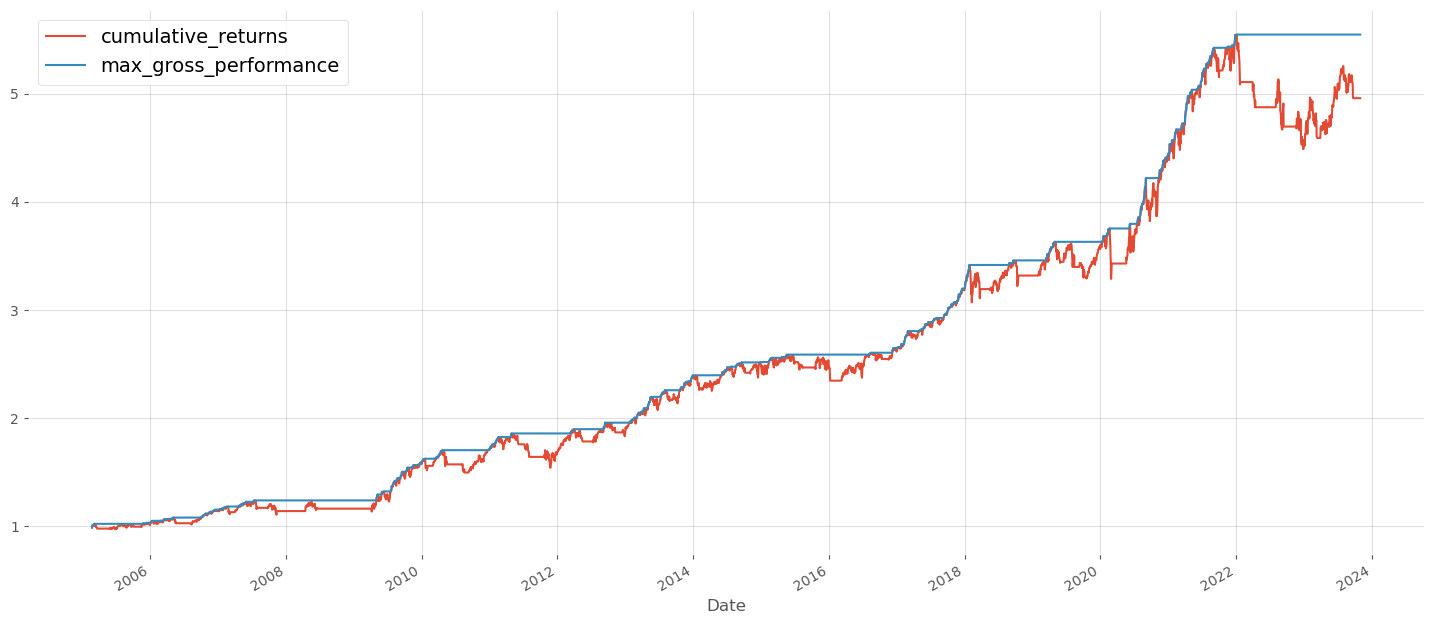

In [31]:
(
    SP500
    [["cumulative_returns", "max_gross_performance"]]
    .dropna()
    .plot(figsize = [18, 8]
         )
)

In [32]:
drawdown = SP500["max_gross_performance"] - SP500["cumulative_returns"]

drawdown

Date
2005-02-18         NaN
2005-02-22    0.000000
2005-02-23    0.000000
2005-02-24    0.000000
2005-02-25    0.000000
                ...   
2023-10-24    0.588674
2023-10-25    0.588674
2023-10-26    0.588674
2023-10-27    0.588674
2023-10-30    0.588674
Length: 4706, dtype: float64

In [34]:
drawdown.max()


1.0605494365485457

In [35]:
periods =\
(
    drawdown[drawdown == 0].index[ 1 :   ].to_pydatetime()
    -
    drawdown[drawdown == 0].index[   : -1].to_pydatetime()
)

In [38]:
periods.max()

datetime.timedelta(days=655)

The Maximum Drawdown of this strategy is 106%.

The Period of the max drawdown is 655 days.

# <a id = "writeup"></a><font color = "orange">4. Write-Ups</font> [back to table of contents](#toc)

## <font color = "blue">Critique</font>

> Survivorship Bias

- Use Historical Constituent Data: We should include in the analysis all companies that have been in the SP500 index in the previous 20 years, not just the companies currently in the index. This means we find out which companies are missing and extract their data to include them in the analysis.

- Adjust for Index Rebalancing: The S&P 500 periodically rebalances its constituents, We may need to regularly update our list of constituents during different analysis period. For our 20 years period, we could divide it into several parts and analyze them separately to reflect different company compositions.

> Market Regime Shift

- Our in-sample backtesting period includes diverse market phases, such as the 2008 financial crisis, the COVID-19 pandemic as well the the Russian-Ukraine war. These varying market conditions present unique challenges and opportunities, and a strategy that excels in one market environment might underperform in another. This is especially more pertinent, given that the model seems to do better after 2020, and this is likely because the models were trained with features that have generally been able to weather and even perform well coming out from the crisis. However, past performance is no guarantee of future performances, it remains to be seen if these stocks which have performed well will continue to do so in the future.

- Adaptive Parameters: Modify the Bollinger Bands settings (like the moving average period and standard deviation multipliers) based on current market volatility. In more volatile markets, wider bands can reduce false trading signals, aligning better with the increased price fluctuations.In our strategy, we use the higher upper bound multiplier to reduce false selling signal and capture more profit opprtunities.

- Dynamic Risk Management: Implement a flexible risk management approach that adjusts to market conditions. This might involve varying the position sizes or employing different stop-loss strategies during periods of high volatility, thereby protecting your trades from sudden market shifts.

- Backtest Across Regimes: Extensively backtest your strategy across different market phases (such as bull, bear, and sideways markets). This helps to ensure that your strategy is robust and can adapt to various market environments, not just the ones it was originally optimized for.


> High downside risk

- Over the in-sample backtesting period, the maximum drawdown under the various model were relatively high (most models had drawdowns of more than 100%) spanning across a significant duration of time (between 170 - 600 days). These are values which are unlikely to be palatable for any fund, and in reality most likely a stop-loss would have been enforced and the investment pulled before even realising the high gains from 2020 onwards.

> Lookahead Bias

- Overly Optimistic Forecast: In the mean reversion strategy, our upper bound multiplier is larger than the lower bound multiplier, which is due to the outstanding performance of the S&P 500 over the past 20 years. This leads to a questionable assumption that the S&P 500 will continue to perform well. Therefore, a revision of the strategy may be required if it is implemented in the long term.

- Use Only Available Data at the Time of Trade: Adjusted closing prices are used as the key data in the analysis. In reality, it would be better practice to ensure all data, including SMA and Bollinger Bands calculations, are based only on information available up to the day before each trade, not including any subsequent data revisions, so that bias can be reduced.

- We note that performance of most models marginally exceeded, and at times had returns less than SPY returns for the period 2008 to 2020. It is more than likely that such a model would not have been considered for implementation, or let alone be sustained for such a long period of time. Performance of models only improved from 2020 onwards. While in hindsight we can observe that the model has returned relatively favourable performance in recent times, we must be cognizant of the fact that earlier performance were less than stellar and did not outperform the market significantly.

> Strategy evaluation is not fully robust

- The strategy is built based on what we have learned so far, which is insufficient and easily replicable compared to real-world strategies. The strategy would become crowded if everyone started to employ similar strategies.

- Real-world Conditions: Factor in real-world trading elements such as market liquidity, and execution delays to realistically assess the strategy's performance in actual market conditions.
  
- In our evaluations, we did not factor in transaction costs such as commission fees or taxes, which would serve to inflate the actual returns we would have realised from the model. We illustrate this through the following example using ARIMA model as the basis of calculations.


> Simple Cost Evaluation Analysis

In the `ARIMA` model, a total of 678 buying and shorting positions were adopted, which would have translated into significant fees. Assuming a flat 0.05% fee per transaction, the outcome would change as follows:

In [110]:
# ARIMA model testing
best_set = "Set_21"
fee = 0.0005
initial = 1e5

cost_analysis = good_returns[best_set][2][["trend_Strategy_Returns", "trend_follow_signal"]]
cost_analysis["positions"] = cost_analysis["trend_follow_signal"].shift(1).diff() / 2
cost_analysis["positions"] = cost_analysis["positions"].fillna(1)
cost_analysis["Actual_Cummulative_Returns"] = initial
for i in range(1, len(cost_analysis)):
    cost_analysis["Actual_Cummulative_Returns"].iloc[i] =\
    (
        cost_analysis["Actual_Cummulative_Returns"].iloc[i-1] * (1 - fee * abs(cost_analysis["positions"].iloc[i]))
        *
        (np.exp(cost_analysis["trend_Strategy_Returns"].iloc[i]))
    )

In [111]:
cost_analysis["Actual_Cummulative_Returns"][-1]

405753.58107530983

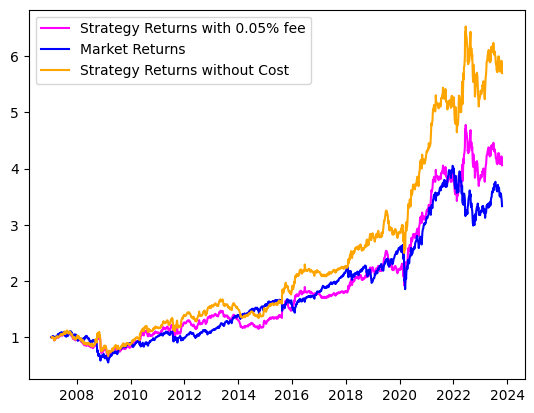

In [116]:
plt.plot((1+cost_analysis["Actual_Cummulative_Returns"].pct_change()).cumprod(), "magenta", label = f"Strategy Returns with {fee*100}% fee")
plt.plot(np.exp(good_returns[best_set][2]["Actual_Returns"]).cumprod(), "blue", label = "Market Returns")
plt.plot(np.exp(cost_analysis["trend_Strategy_Returns"]).cumprod(), "orange", label = "Strategy Returns without Cost")
plt.legend()

- We can observe that we would have made a smaller overall gain instead, with a reduction of returns by 28.8%.
- We also note that for majority of the investment period, overall returns from strategy were lesser than SPY returns

# <a id = "statement"></a><font color = "orange">5. Contribution Statements</font> [back to table of contents](#toc)

> Li Lingwei

- Built a trading strategy based on supervised machine learning models, utilizing historical price returns together with various momentum-based indicators to identify potential trade opportunities.
- Covered models such as Random Forests, Support Vector Machines, Elastic Net etc.
- Conducted Performance Analysis on Strategy output.
- Contributed to the self-critique portion for supervised machine learning models.
- Identified various areas to further improve the strategy analysis

> Leong Yu Rong

- Built a trading strategy based on ARIMA model, utilizing historical price return together with various momentum based indicators to identify potential trade opportunities.
- Developed code to iterate through various combinations of input and technical features to identify a model that generates better than market returns.
- Conducted Performance Analysis on Strategy output.
- Contributed to the self-critique portion for ARIMA models.
- Assisted to compile the final report.

> Varun Chitalia

- Built a trading strategy based on the Simple Moving Average principle, utilizing historical price return to identify potential trade opportunities.
- Constructed a for loop in the strategy to iteratively test different sets of parameters to determine the most effective combination.
- Conducted Performance Analysis on Strategy output.

> Xia Tian

- Built a trading strategy based on the mean reversion principle, utilizing historical price return to identify potential trade opportunities.
- Conducted Performance Analysis on Strategy output.
- Assisted in Writing Strategy Explanations and Self-Critique

> Zhou Tianqi

- Built a trading strategy based on the mean reversion principle, utilizing historical price return to identify potential trade opportunities.
- Constructed a for loop in the strategy to iteratively test different sets of parameters to determine the most effective combination.
- Conducted Performance Analysis on Strategy output.
- Assisted in Writing Strategy Explanations and Self-Critique
- Investigated using other trading strategies like Moving Average Convergence Divergence and Relative Strength Index. Decided not to use these strategies after detailed analysis revealed poor performance 